In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sipm.sipm as sipm
import sipm.dataset as ds
from scipy.optimize import curve_fit
from scipy.special import erfc, gamma
from scipy.signal import butter, lfilter
from scipy.signal import find_peaks

In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def gauss(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))/np.sqrt(2*np.pi)/c

def line(x,a,b):
    return a*x+b

def line_vbd(x,a,vbd):
    return a*(x-vbd)

def compound_poisson(x,n,mu,p):
    k = [int(x_+0.5) for x_ in x]
    ans = []
    for k_ in k:
        if k_==0:
            ans.append(np.exp(-mu))
        else:
            ans_ = 0
            for i in range(1,k_+1):
                ans_ += gamma(k_+1)*gamma(k_)/gamma(i+1)/gamma(i)/gamma(k_-i+1)*(mu*(1-p))**i*p**(k_-i)
            ans.append(n*ans_*np.exp(-mu)/gamma(k_+1))
    return ans

# Top tile calibration (0928 data)

The 0928 datasets use laser pulses as the external trigger.

## Directories

In [4]:
data_dir = "/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/"
subdir = ['20220928_top_61V_laser_ext/',
          '20220928_top_63V_laser_ext/',
          '20220928_top_65V_laser_ext/',
          '20220928_top_67V_laser_ext/',
          '20220928_top_69V_laser_ext/']

## Process raw data and get:
* charge histograms
* filtered amplitude histograms
* average waveform

In [5]:
datasets = []
for subdir_ in subdir:
    path = "{}{}".format(data_dir, subdir_)
    data = ds.Dataset(path, pol=-1, channels=range(4), samples=2048)
    print(path)
    for i in range(4):
        data.ch[i].read_data(header=False)
        data.ch[i].baseline_subtraction()
        data.ch[i].get_integral(short=1.6, long=5)
        data.ch[i].get_integral_hist(short=[-5e2,5e3,1000], long=[-5e2,5e3,1000])
        data.ch[i].ar_filter(tau=20)
        data.ch[i].get_famp()
        data.ch[i].get_famp_hist(bin=[-1e2,1e3,1000])
        data.ch[i].clear()
    datasets.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_top_61V_laser_ext/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_top_63V_laser_ext/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_top_65V_laser_ext/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_top_67V_laser_ext/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_top_69V_laser_ext/


## Plot charge histogram and analyze

Channel 0 Vbd=53.877+/-0.331V slope=42.429+/-1.197
Channel 1 Vbd=54.896+/-0.136V slope=41.077+/-0.641
Channel 2 Vbd=54.488+/-0.180V slope=42.923+/-0.839
Channel 3 Vbd=55.371+/-0.067V slope=44.466+/-0.497


Text(0.5, 0.98, 'Breakdown Voltage (Top)')

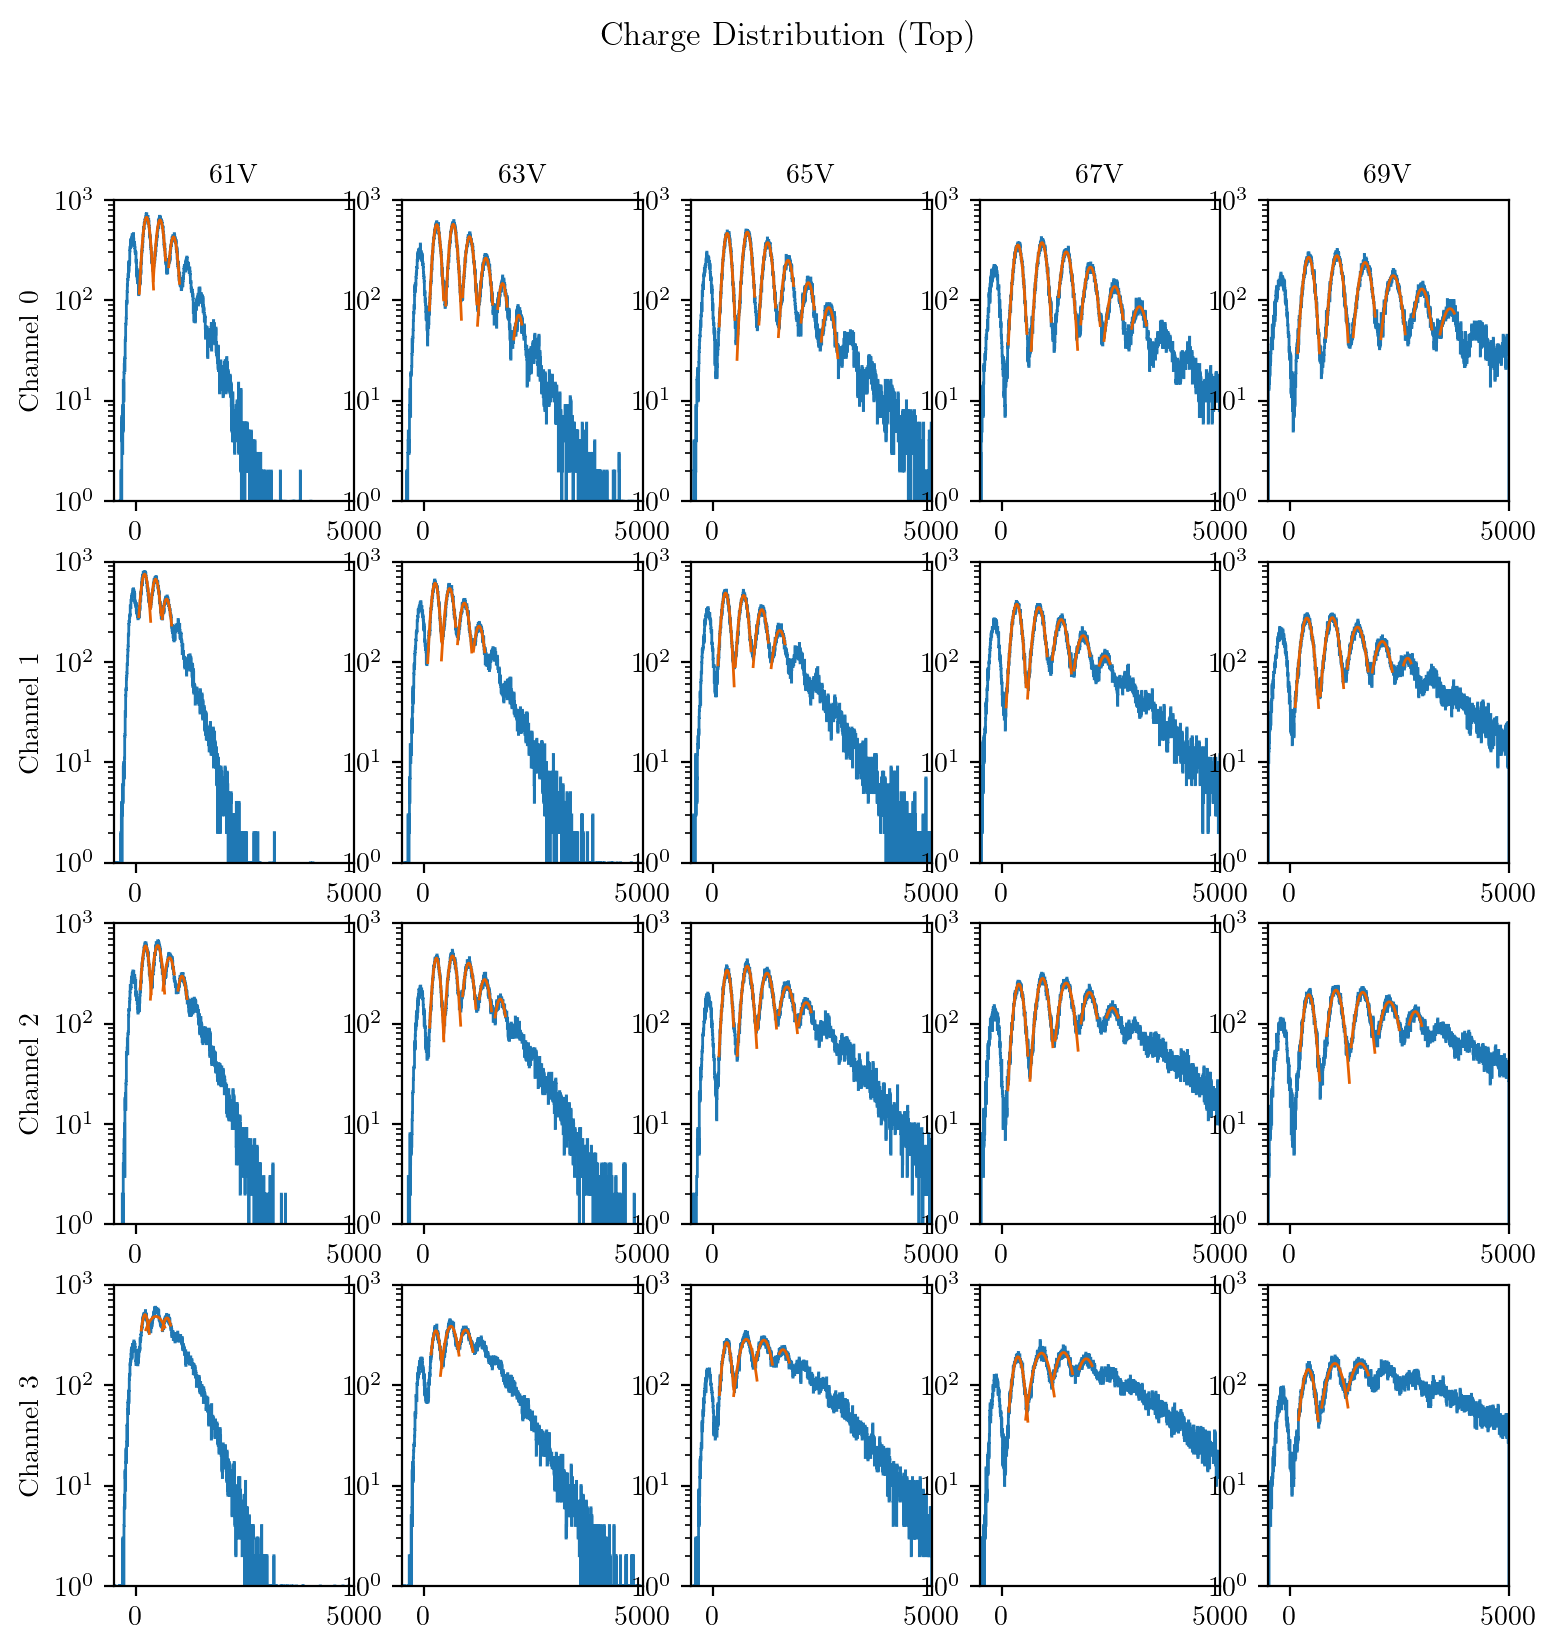

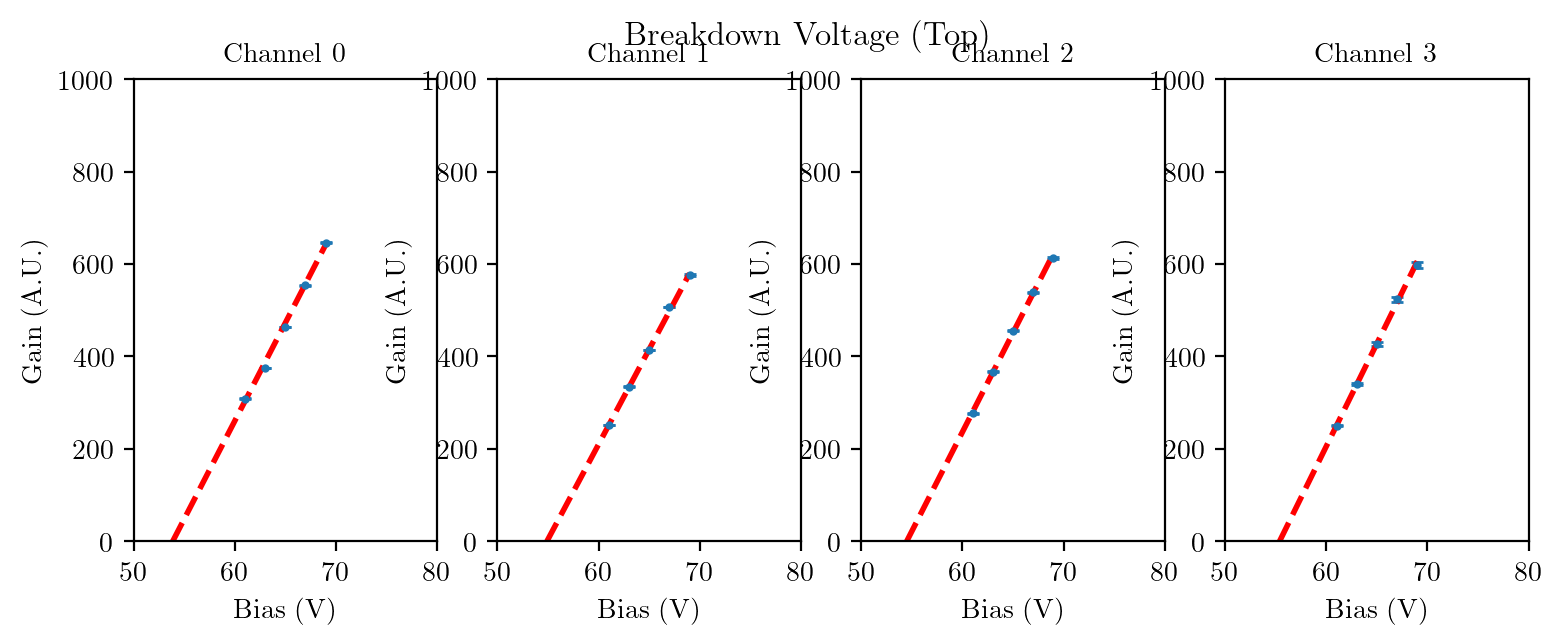

In [6]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
bias = [61, 63, 65, 67, 69]
Vbd_charge_top = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(datasets): 
        #charge histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].integral_short_hist, data.ch[ch].integral_short_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].integral_short_hist_bin[0], data.ch[ch].integral_short_hist_bin[-1])
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        thre = 100 #threshold to remove baseline noise
        peaks,pdict = find_peaks(data.ch[ch].integral_short_hist[thre:], prominence=60, width=15, distance=20)
        #fit pe peaks with Gaussian
        pe_mean = []
        bin_width = data.ch[ch].integral_short_hist_bin[1]-data.ch[ch].integral_short_hist_bin[0]
        peak_range = []
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + thre
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = bin_width*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = data.ch[ch].integral_short_hist_bin[0] + bin_width*min_bin
            max_x = data.ch[ch].integral_short_hist_bin[0] + bin_width*max_bin
            peak_x = data.ch[ch].integral_short_hist_bin[0] + bin_width*peak_bin
            popt,pcov = curve_fit(gauss, data.ch[ch].integral_short_hist_bin[min_bin:max_bin], data.ch[ch].integral_short_hist[min_bin:max_bin], p0=[data.ch[ch].integral_short_hist[peak_bin], peak_x, pe_width_x], sigma=np.sqrt(data.ch[ch].integral_short_hist[min_bin:max_bin]), maxfev=10000)
            plt.plot(data.ch[ch].integral_short_hist_bin[min_bin:max_bin], gauss(data.ch[ch].integral_short_hist_bin[min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
            pe_mean.append([popt[1],np.sqrt(pcov[1,1])])
            peak_range.append([popt[1]-2*popt[2],popt[1]+2*popt[2]])    
        data.ch[ch].set_calibration(integral_peaks=peak_range)
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = np.array(pe_mean)[:,0]
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=np.array(pe_mean)[:,1], maxfev=10000)
        data.ch[ch].set_calibration(gain_integral=[popt[0], np.sqrt(pcov[0,0])])
    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].gain_integral[0] for data in datasets]
    err = [data.ch[ch].gain_integral[1] for data in datasets]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], sigma=err, maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_charge_top[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o',markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,1000)
        
plt.figure(0)
plt.suptitle('Charge Distribution (Top)')
# plt.savefig('../plots/sipm/charge_histo_top_0928.pdf')
plt.figure(1)
plt.suptitle('Breakdown Voltage (Top)')
# plt.savefig('../plots/sipm/gain_bias_charge_top_0928.pdf')

## Plot filtered amplitude histogram and analyze

n=109967 mu=1.924 p=0.085+/-0.007
n=109255 mu=2.134 p=0.127+/-0.006
n=108785 mu=2.276 p=0.171+/-0.007
n=108792 mu=2.345 p=0.231+/-0.009
n=107250 mu=2.420 p=0.282+/-0.006
Channel 0 Vbd=55.259+/-0.087V slope=9.369+/-0.097
n=110319 mu=1.794 p=0.087+/-0.006
n=110536 mu=1.966 p=0.142+/-0.012
n=109369 mu=2.096 p=0.183+/-0.012
n=109704 mu=2.134 p=0.246+/-0.008
n=106418 mu=2.271 p=0.271+/-0.013
Channel 1 Vbd=55.276+/-0.085V slope=8.870+/-0.072
n=109971 mu=2.247 p=0.096+/-0.005
n=109685 mu=2.524 p=0.137+/-0.003
n=108329 mu=2.707 p=0.177+/-0.001
n=107968 mu=2.764 p=0.237+/-0.005
n=108184 mu=2.873 p=0.300+/-0.002
Channel 2 Vbd=55.150+/-0.118V slope=8.974+/-0.087
n=109663 mu=2.509 p=0.091+/-0.003
n=109637 mu=2.761 p=0.146+/-0.004
n=108931 mu=2.926 p=0.192+/-0.004
n=108884 mu=3.032 p=0.254+/-0.005
n=108115 mu=3.167 p=0.304+/-0.004
Channel 3 Vbd=55.230+/-0.090V slope=8.412+/-0.079


(0.0, 0.4)

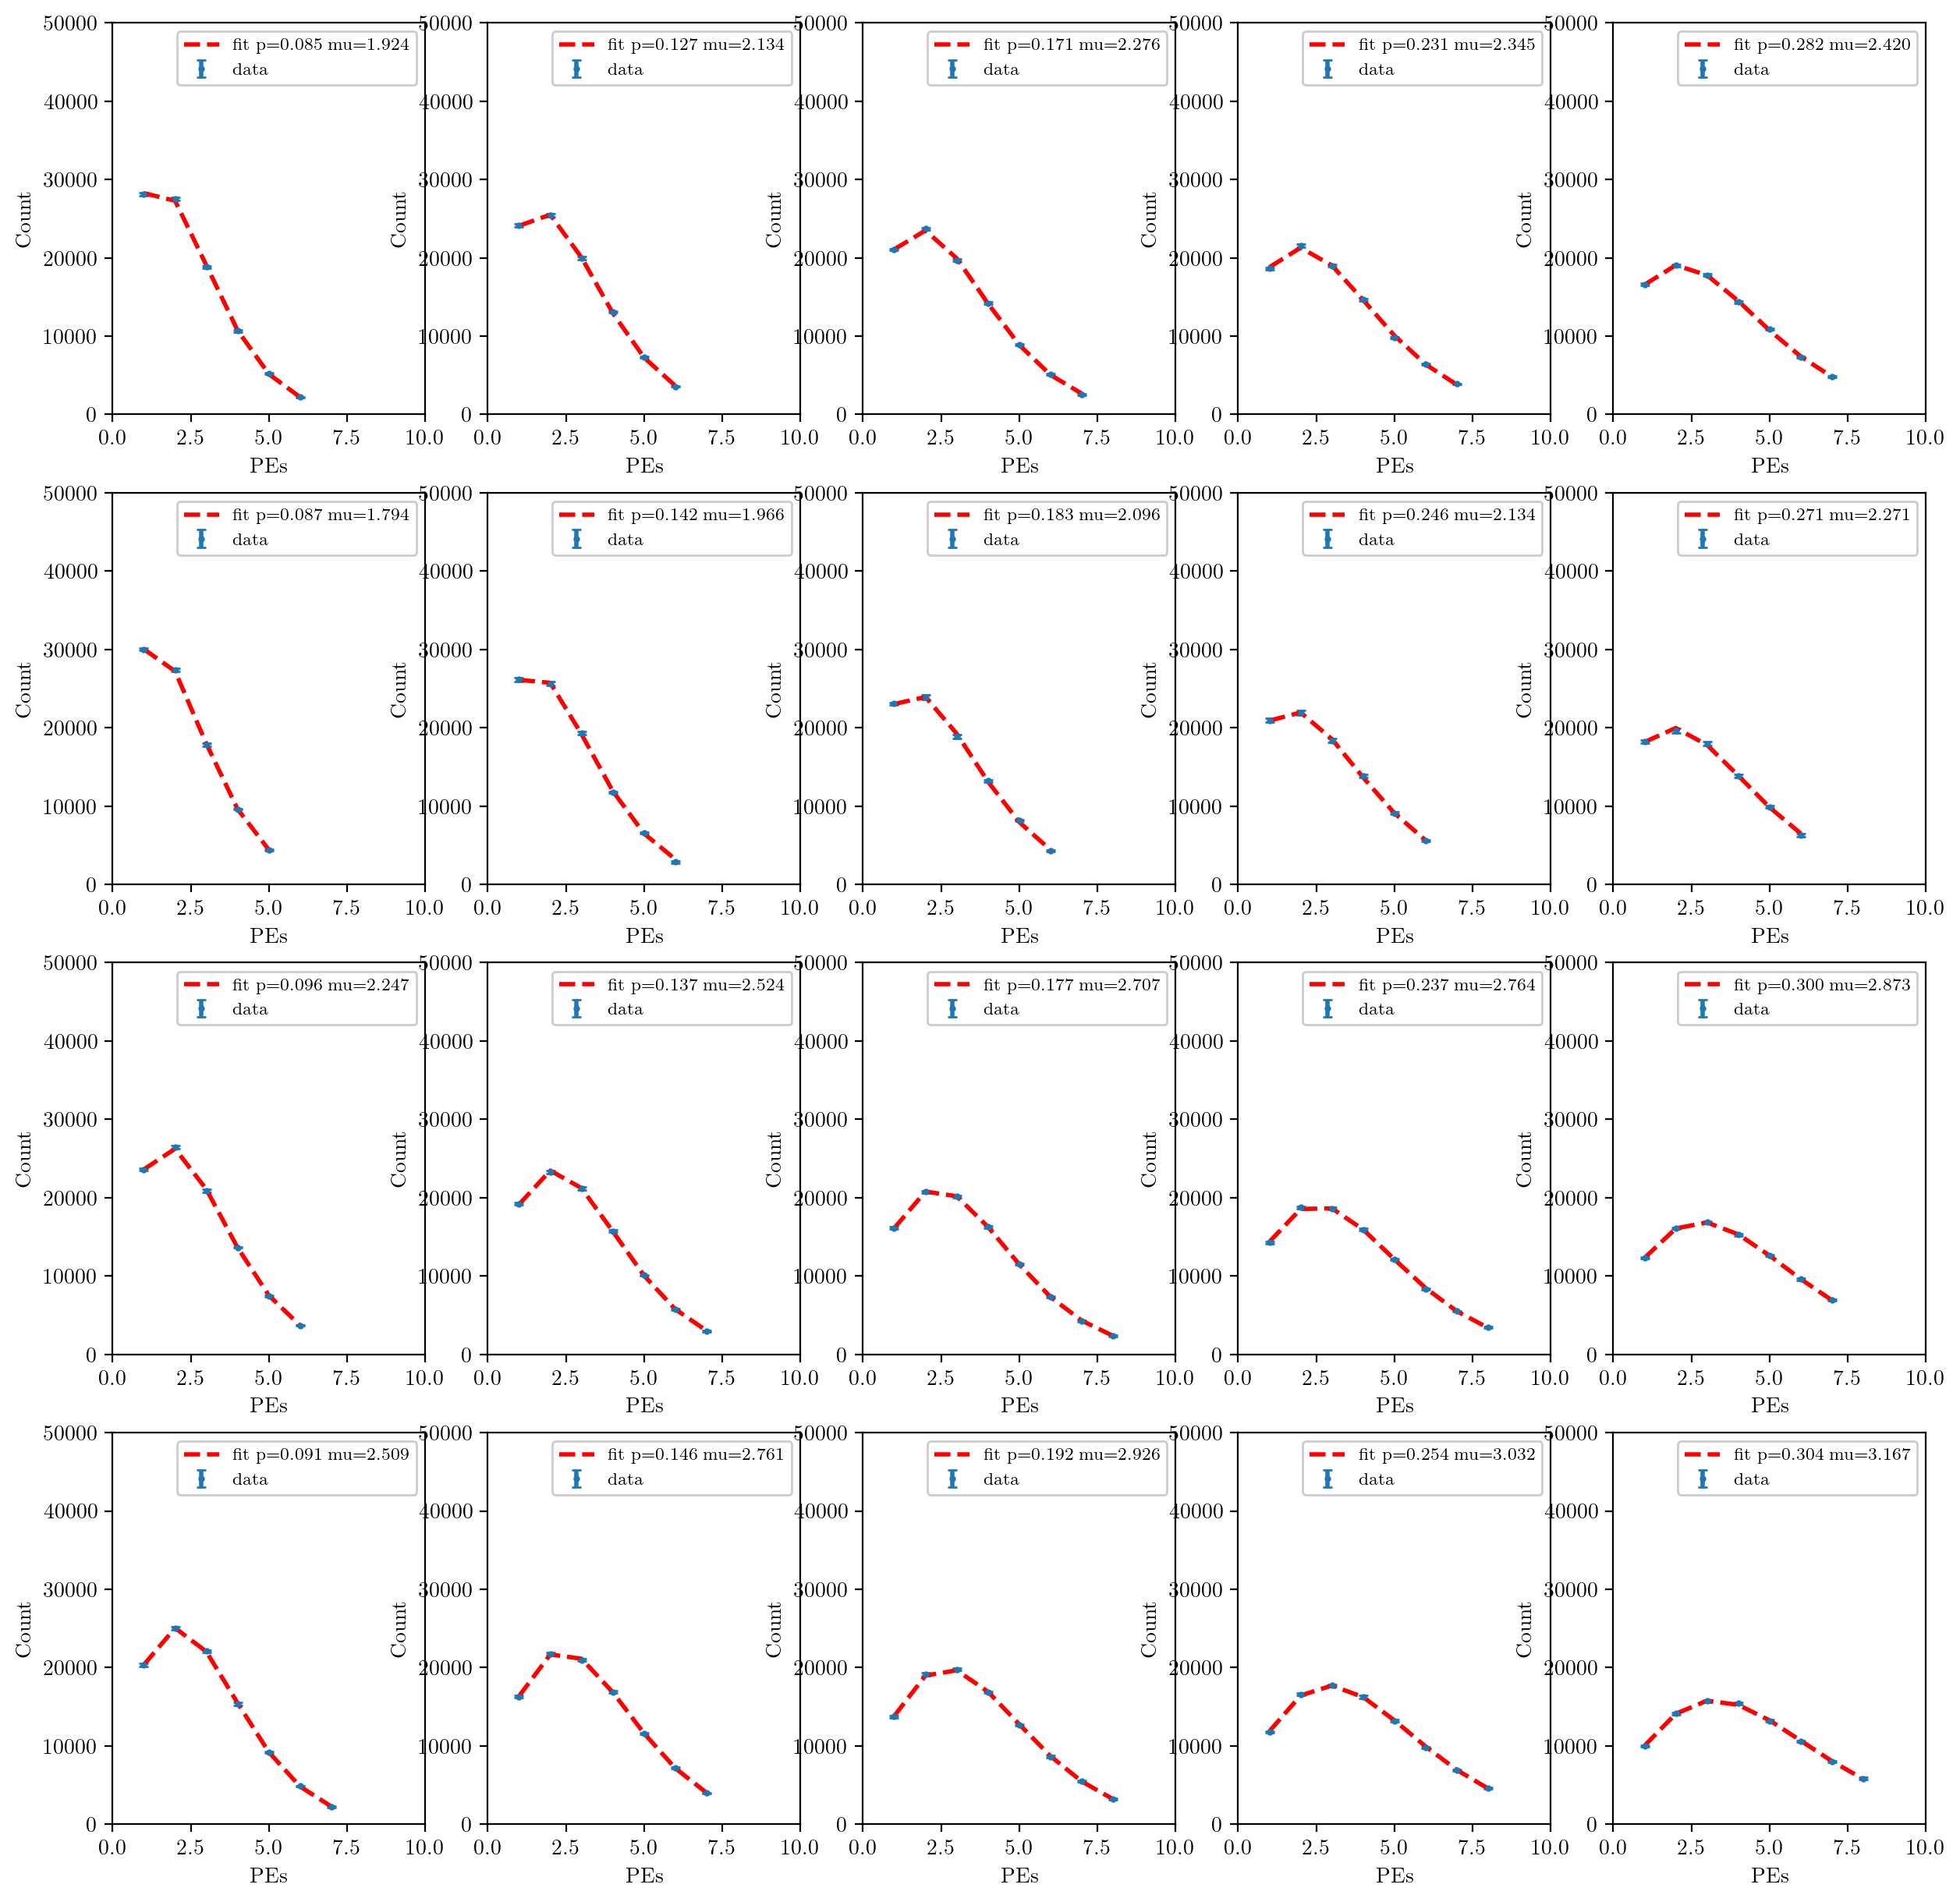

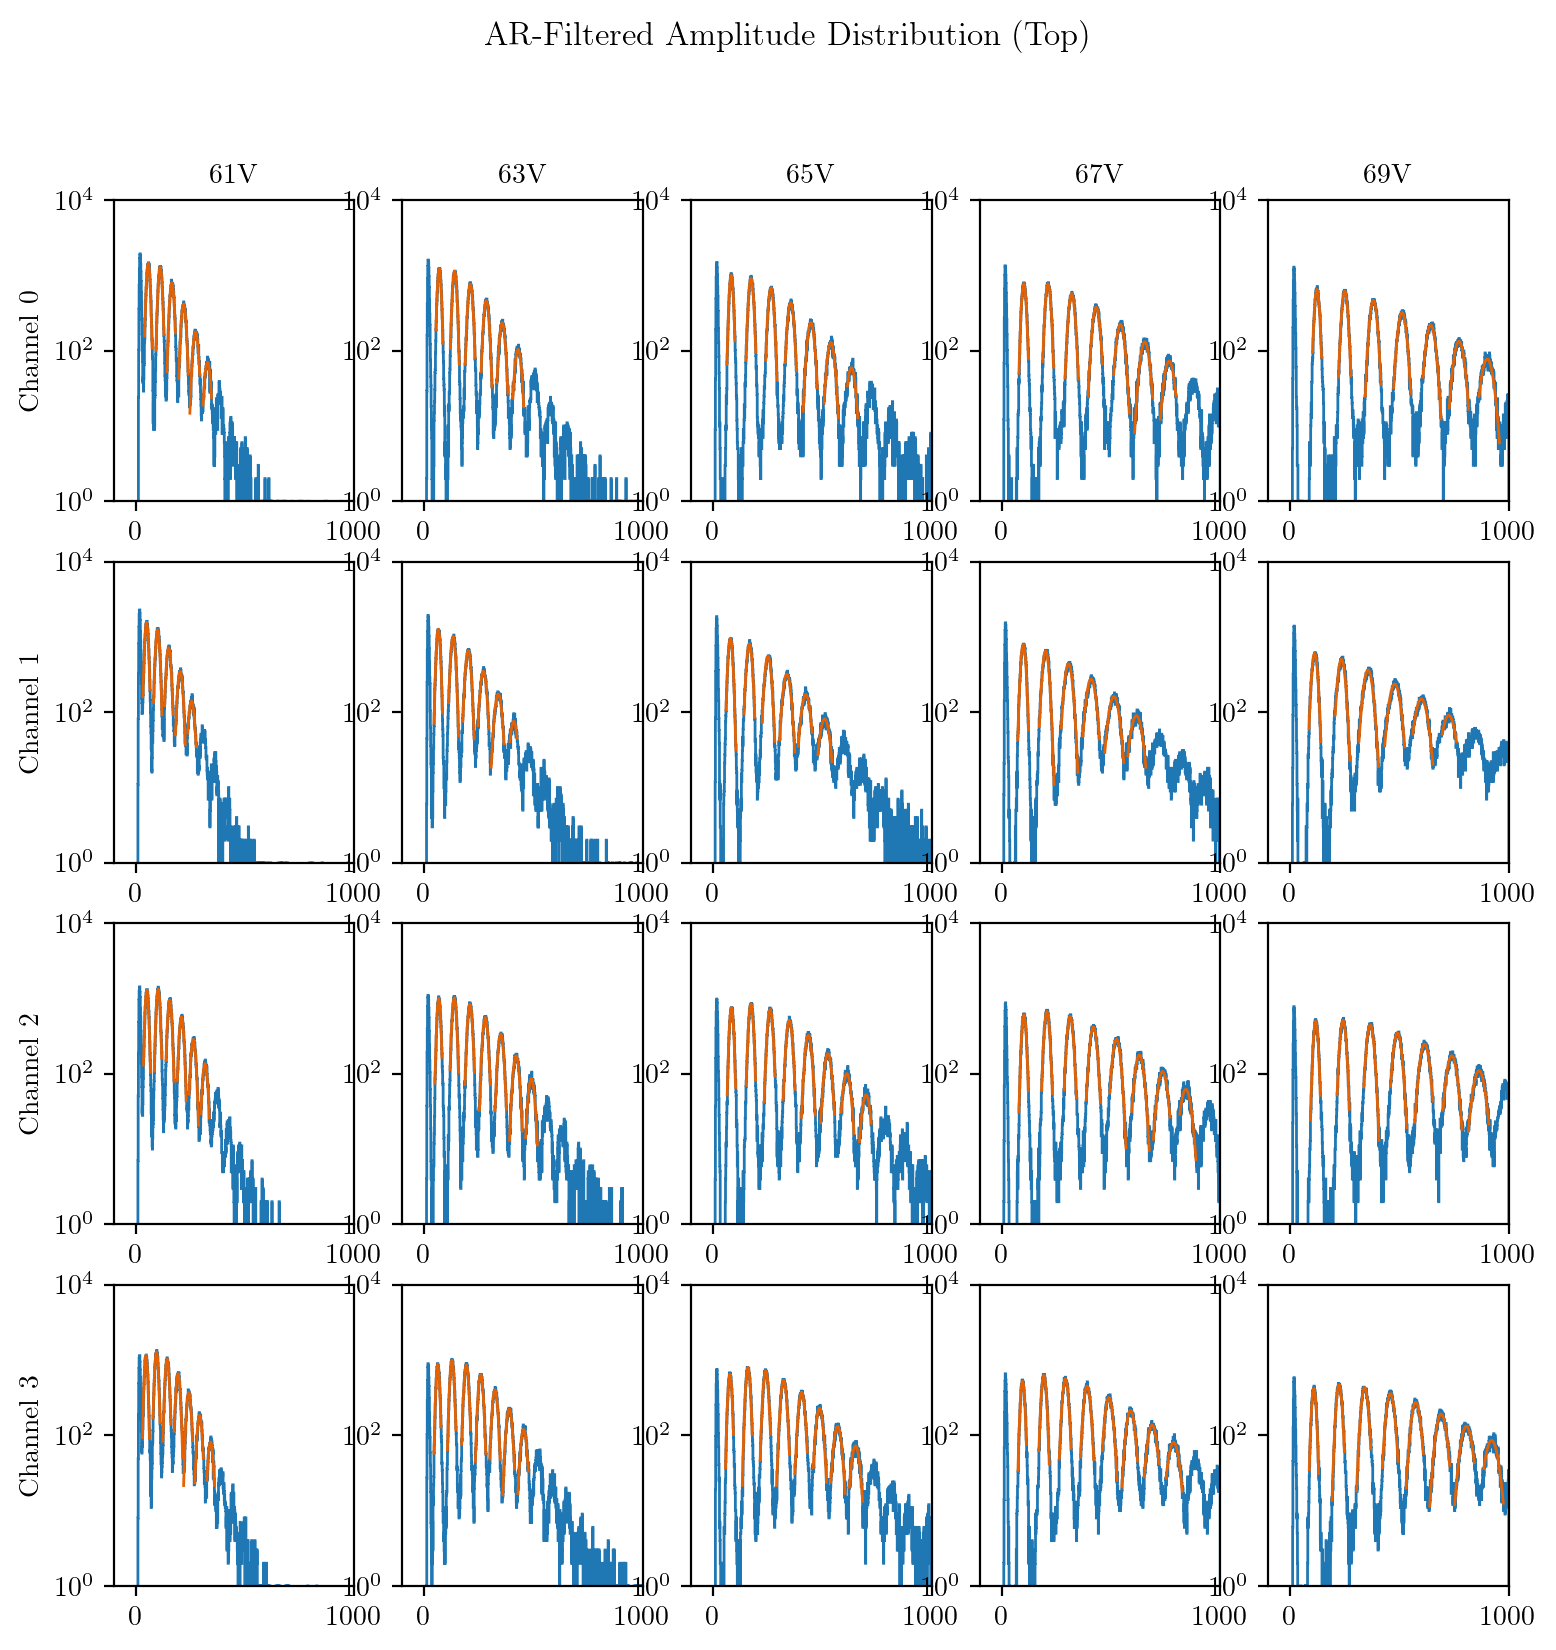

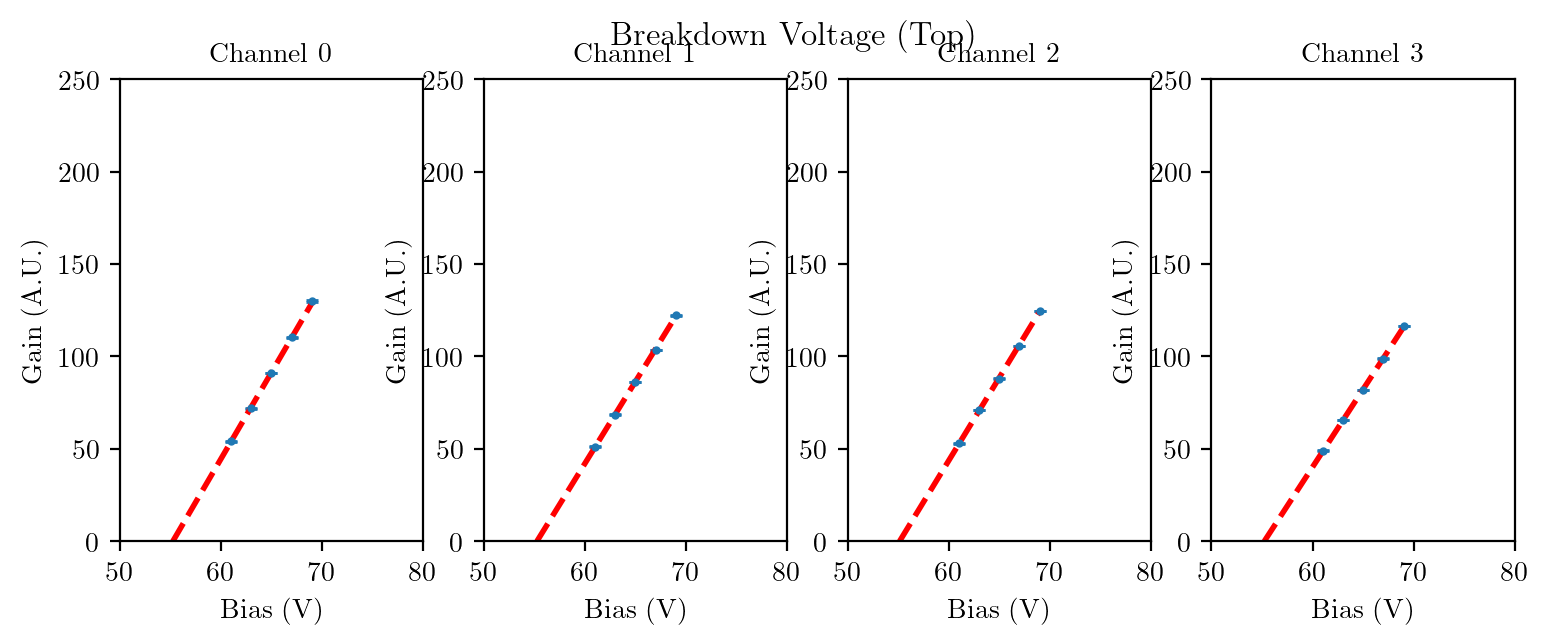

In [7]:
plt.figure(0,figsize=(9,9))#for filtered amplitude histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
plt.figure(2,figsize=(15,15))#for Vinogradov fit
plt.figure(3,figsize=(5,5)) # for crosstalk summary
bias = [61, 63, 65, 67, 69]
Vbd_famp_top = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(datasets):  
        #filtered amplitude histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].famp_hist_bin[0], data.ch[ch].famp_hist_bin[-1])
        plt.ylim(1, 1e4)
        # find pe peaks in histogram
        thre = 30
        peaks,pdict = find_peaks(data.ch[ch].famp_hist[thre:], prominence=60, width=15, distance=20)
        #fit pe peaks with Gaussian
        pe_mean = []
        pe_norm = []
        peak_range = []
        bin_width = data.ch[ch].famp_hist_bin[1]-data.ch[ch].famp_hist_bin[0]
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + thre
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = bin_width*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = data.ch[ch].famp_hist_bin[0] + bin_width*min_bin
            max_x = data.ch[ch].famp_hist_bin[0] + bin_width*max_bin
            peak_x = data.ch[ch].famp_hist_bin[0] + bin_width*peak_bin
            popt,pcov = curve_fit(gauss, data.ch[ch].famp_hist_bin[min_bin:max_bin], data.ch[ch].famp_hist[min_bin:max_bin], p0=[data.ch[ch].famp_hist[peak_bin], peak_x, pe_width_x], sigma=np.sqrt(data.ch[ch].famp_hist[min_bin:max_bin]), maxfev=10000)
            plt.plot(data.ch[ch].famp_hist_bin[min_bin:max_bin], gauss(data.ch[ch].famp_hist_bin[min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
            pe_mean.append([popt[1],np.sqrt(pcov[1,1])])
            pe_norm.append([popt[0],np.sqrt(pcov[0,0])])
            peak_range.append([popt[1]-2*popt[2],popt[1]+2*popt[2]])
        data.ch[ch].set_calibration(famp_peaks=peak_range)
        
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = np.array(pe_mean)[:,0]
        err = np.array(pe_mean)[:,1]
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=err, maxfev=10000)
        data.ch[ch].set_calibration(gain_famp=[popt[0],np.sqrt(pcov[0,0])])
        #Vinogradov fit
        plt.figure(2)
        plt.subplot(4,5,ch*5+i+1)
        plt.errorbar(np.arange(1,len(pe_norm)+1), np.array(pe_norm)[:,0], yerr=np.array(pe_norm)[:,1], fmt='o', markersize=2, label='data')
        popt,pcov = curve_fit(compound_poisson, list(np.arange(1,len(pe_norm)+1)), np.array(pe_norm)[:,0], p0=[1e5, 2, 0.3], sigma=np.array(pe_norm)[:,1], maxfev=10000)
        print('n={:.0f} mu={:.3f} p={:.3f}+/-{:.3f}'.format(*popt, np.sqrt(pcov[2,2])))
        data.ch[ch].set_correlated_noise(ct=[popt[2],np.sqrt(pcov[2,2])])
        plt.plot(np.arange(1,len(pe_norm)+1), compound_poisson(np.arange(1,len(pe_norm)+1),*popt), 'r--', label='fit p={:.3f} mu={:.3f}'.format(popt[2],popt[1]))
        plt.ylim(0,5e4)
        plt.xlim(0,10)
        plt.xlabel('PEs')
        plt.ylabel('Count')
        plt.legend(loc='upper right')
    # plot crosstalk
    plt.figure(3)
    plt.errorbar(bias, [data.ch[ch].ct[0] for data in datasets], yerr=[data.ch[ch].ct[1] for data in datasets], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].gain_famp[0] for data in datasets]
    err = [data.ch[ch].gain_famp[1] for data in datasets]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_famp_top[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,250)
        

plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution (Top)')
# plt.savefig('../plots/sipm/famp_histo_top_0928.pdf')
plt.figure(1)
plt.suptitle('Breakdown Voltage (Top)')
# plt.savefig('../plots/sipm/gain_bias_famp_top_0928.pdf')
plt.figure(3)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Direct Crosstalk Probability')
plt.xlim(60,70)
plt.ylim(0, 0.4) 

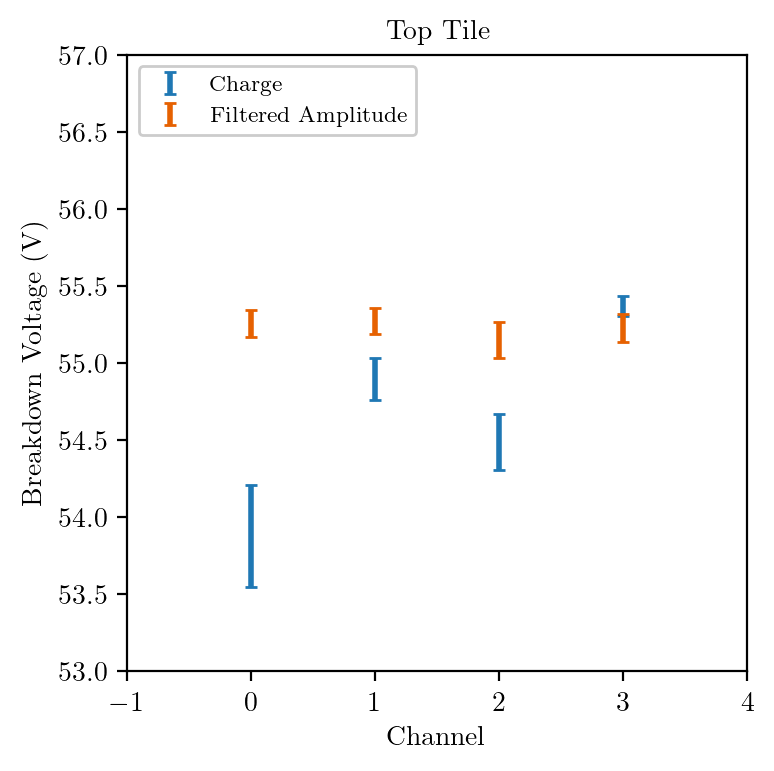

In [8]:
plt.figure(0,figsize=(4,4))
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_charge_top[:,0], yerr=Vbd_charge_top[:,1], label='Charge', ls='none')
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_famp_top[:,0], yerr=Vbd_famp_top[:,1], label='Filtered Amplitude', ls='none')
plt.xlim(-1,4)
plt.ylim(53,57)
plt.xlabel('Channel')
plt.ylabel('Breakdown Voltage (V)')
plt.title('Top Tile')
plt.legend()
plt.show()
# plt.savefig('../plots/sipm/vbd_top_0928.pdf')

## Examine after-pulses
Time window = $5~\rm\mu s$.
$\mu$ of Gaussian fit is regarded as the spe gain, while the overall average is $\mu(1+ap)$ where $ap$ is the afterpulse charge per pe.
The right tails are due to afterpulses.


SPE(1+AP) = 341.37886363046493+/-1.9816801622904265
SPE(1+AP) = 418.5097087812981+/-0.8520871317780695
SPE(1+AP) = 517.9075724034741+/-1.1920976215202193
SPE(1+AP) = 619.611062735779+/-2.079586513913645
SPE(1+AP) = 726.8713622184374+/-1.290866783188477
SPE(1+AP) = 320.3218249463119+/-0.4601301078506389
SPE(1+AP) = 420.40293641990155+/-0.6152220747608679
SPE(1+AP) = 519.5815671469427+/-1.2856908652552554
SPE(1+AP) = 636.6577280513162+/-1.7321256345330638
SPE(1+AP) = 731.1999719691894+/-1.7196566285195418
SPE(1+AP) = 323.6936324686152+/-0.3976497775402055
SPE(1+AP) = 425.39512389397026+/-0.7475709733145949
SPE(1+AP) = 524.1075333155493+/-0.631483083031071
SPE(1+AP) = 626.7094261100046+/-0.9911294045247263
SPE(1+AP) = 718.202985572947+/-0.38873812200435687
SPE(1+AP) = 309.5630813138437+/-0.7492312871856467
SPE(1+AP) = 410.2794902356597+/-0.5231225439262143
SPE(1+AP) = 508.98003331053644+/-0.7463230171906131
SPE(1+AP) = 614.7878081964489+/-0.9488749882589776
SPE(1+AP) = 705.8935505258452+/

(-0.01, 0.06)

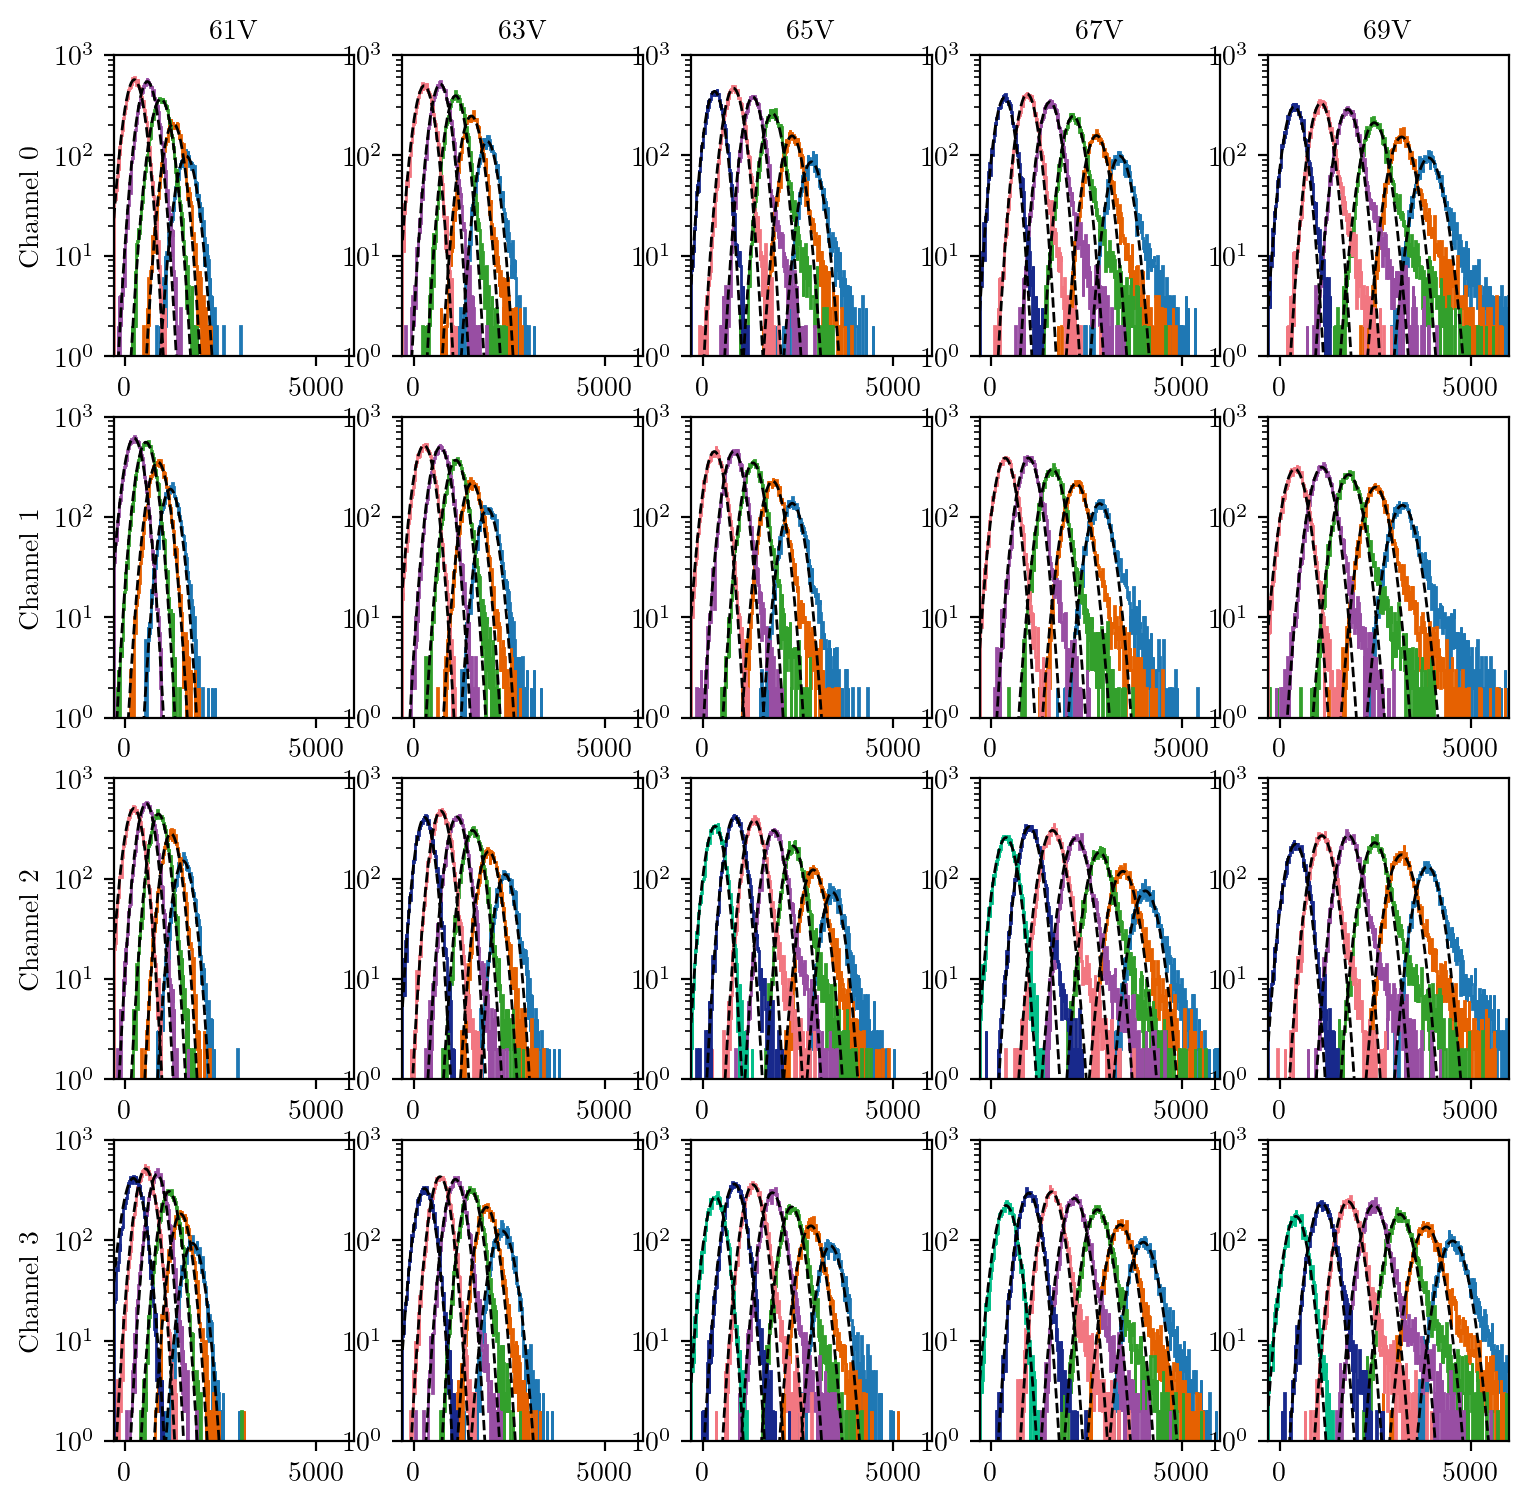

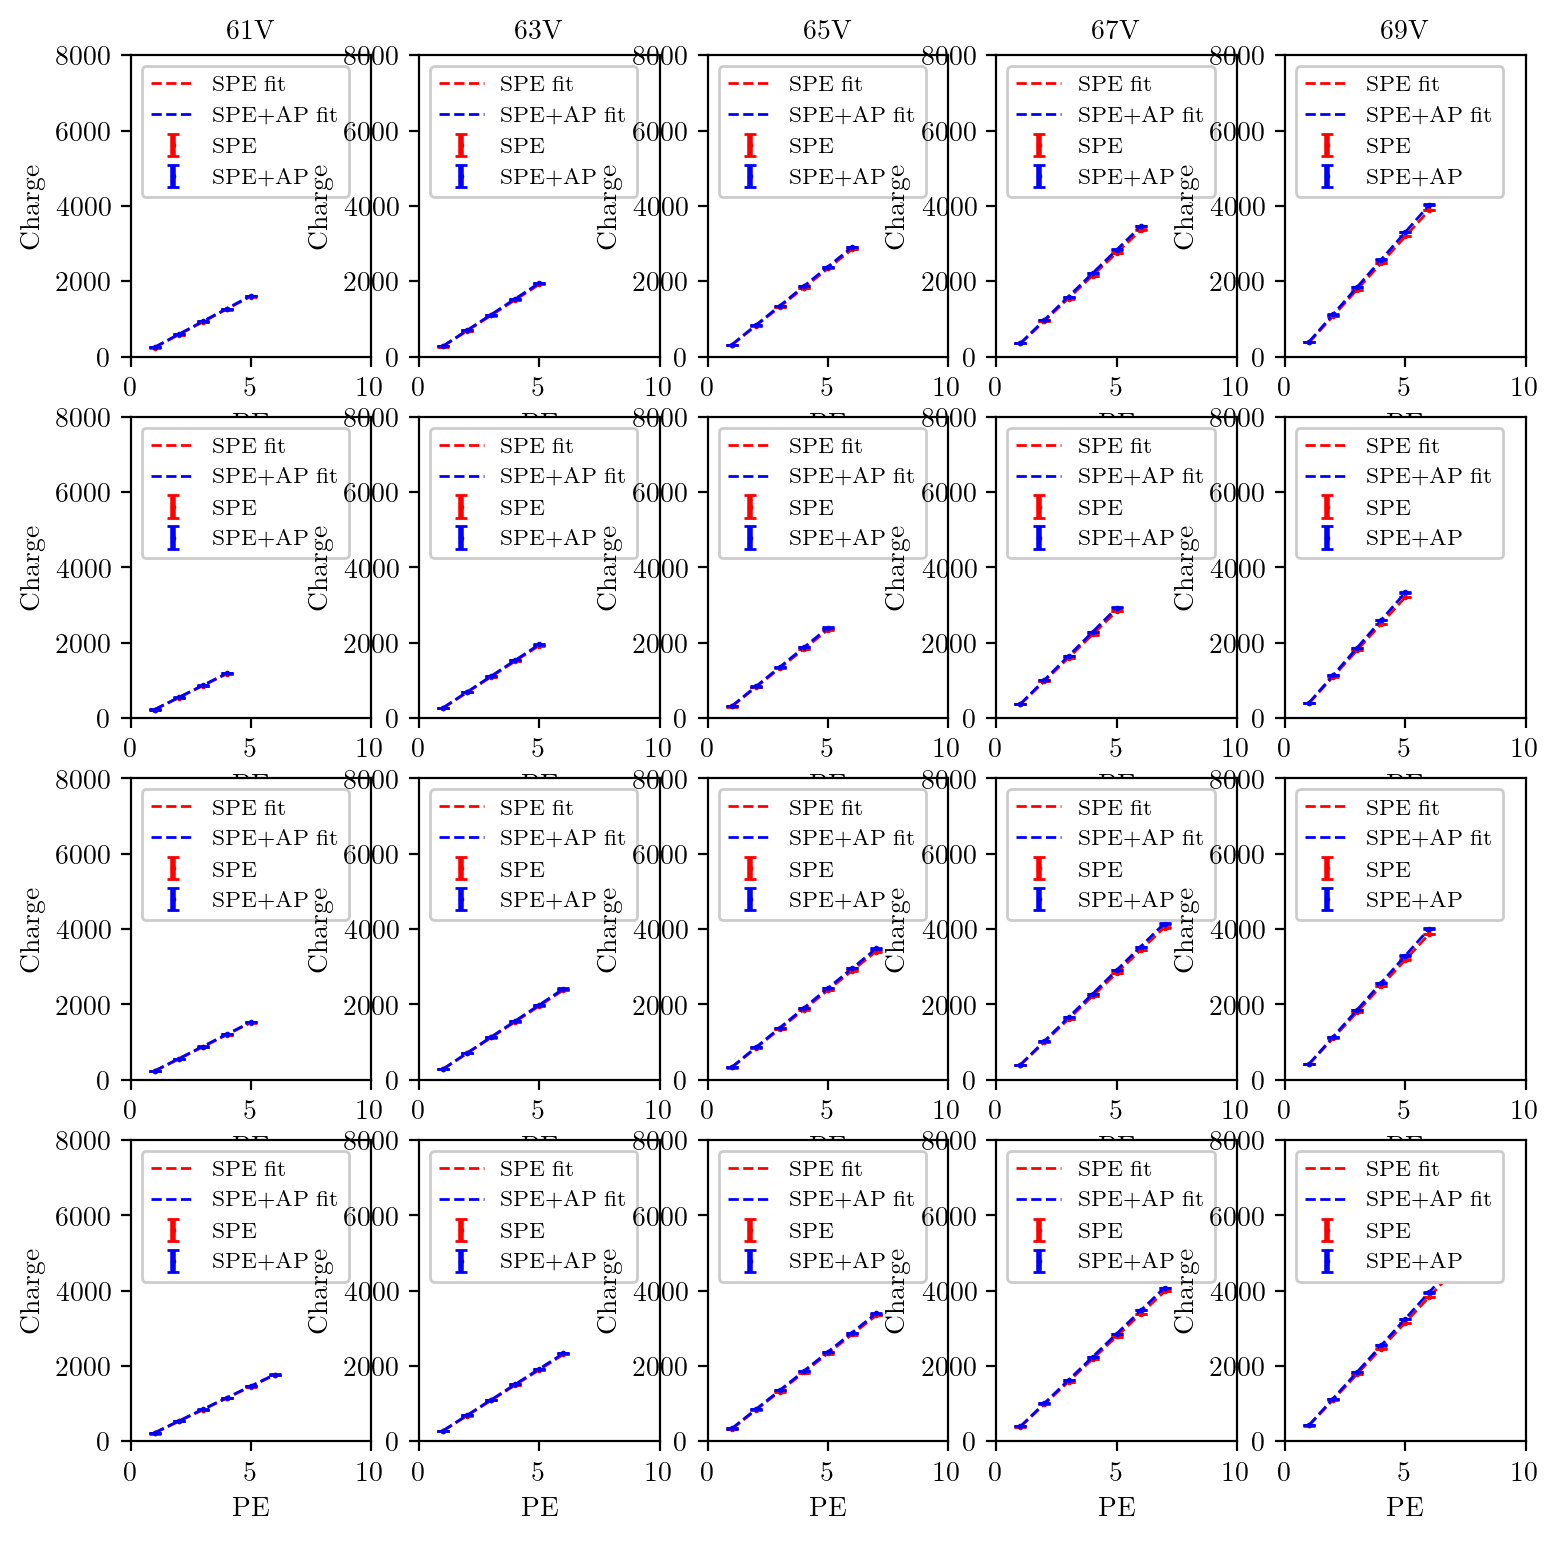

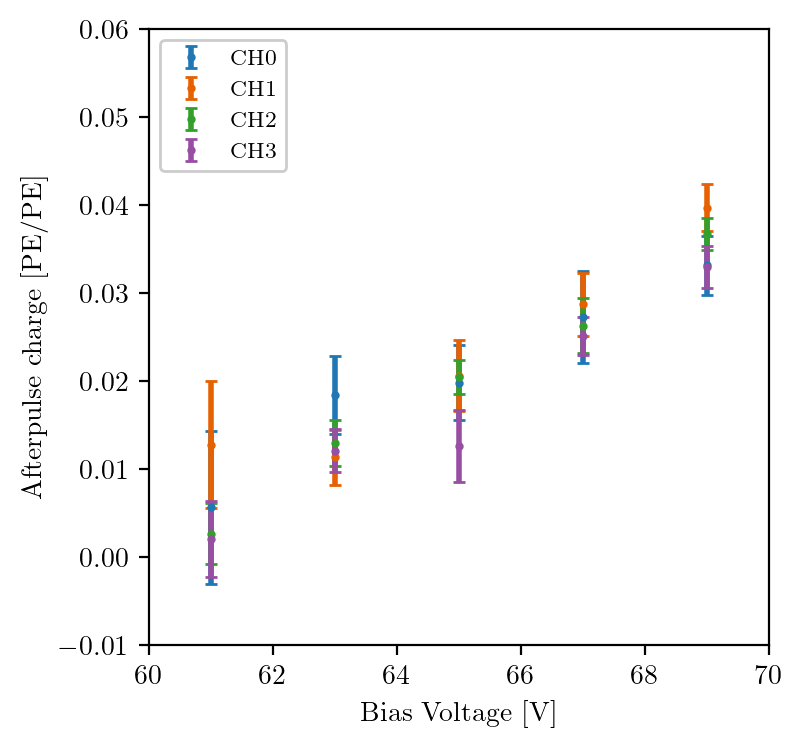

In [9]:
plt.figure(0,figsize=(9,9))
plt.figure(1,figsize=(9,9))
plt.figure(2,figsize=(4,4))

x_min=-300
x_max=6000
n_bins=500

for ch in [0,1,2,3]:
    for i,data in enumerate(datasets):
        mu_pe = []
        avg_pe = []
        data.ch[ch].get_afterpulse_charge(xmin=x_min,xmax=x_max,nbins=n_bins)
        bin_width = (x_max-x_min)/n_bins
        #histogram and Gaussian fit
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        for j in np.arange(len(data.ch[ch].ap_charge)-2,-1,-1):
            plt.stairs(data.ch[ch].ap_charge_hist[j], data.ch[ch].ap_charge_hist_bin[j])
            avg_pe.append([np.mean(data.ch[ch].ap_charge[j]), np.std(data.ch[ch].ap_charge[j])/np.sqrt(len(data.ch[ch].ap_charge[j]))])
            w = int(np.std(data.ch[ch].ap_charge[j])/bin_width) # in bin
            p = np.argmax(data.ch[ch].ap_charge_hist[j]) # in bin
            popt,pcov = curve_fit(gauss, data.ch[ch].ap_charge_hist_bin[j][p-w:p+w], data.ch[ch].ap_charge_hist[j][p-w:p+w], p0=[np.max(data.ch[ch].ap_charge_hist[j])*w*bin_width,p*bin_width,w*bin_width], sigma=np.sqrt(data.ch[ch].ap_charge_hist[j][p-w:p+w]), maxfev=100000)
            plt.plot(data.ch[ch].ap_charge_hist_bin[j][:-1], gauss(data.ch[ch].ap_charge_hist_bin[j][:-1], *popt), 'k--', linewidth=1)
            mu_pe.append([popt[1],np.sqrt(pcov[1,1])])
        plt.xlim(data.ch[ch].ap_charge_hist_bin[0][0], data.ch[ch].ap_charge_hist_bin[0][-1])
        plt.ylim(1,1e3)
        plt.yscale('log')
        # plot mu-pe vs avg-pe
        mu_pe = list(reversed(mu_pe))
        avg_pe = list(reversed(avg_pe))
        plt.figure(1)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(mu_pe)[:,0], yerr=np.array(mu_pe)[:,1], fmt='r.', markersize=2, label='SPE')
        popt,pcov=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(mu_pe)[:,0], p0=[500,0], sigma=np.array(mu_pe)[:,1], maxfev=10000)
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1)+1, line(np.arange(len(data.ch[ch].ap_charge)-1)+1, *popt), 'r--', label='SPE fit', linewidth=1)
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(avg_pe)[:,0], yerr=np.array(avg_pe)[:,1], fmt='b.', markersize=2, label='SPE+AP')
        popt_,pcov_=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1)+1,np.array(avg_pe)[:,0], p0=[500,0], sigma=np.array(avg_pe)[:,1], maxfev=10000)
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1)+1, line(np.arange(len(data.ch[ch].ap_charge)-1)+1, *popt_), 'b--', label='SPE+AP fit', linewidth=1)
        plt.xlabel('PE')
        plt.ylabel('Charge')
        data.ch[ch].set_correlated_noise(ap=[popt_[0]/popt[0]-1, popt_[0]/popt[0]*np.sqrt(pcov[0,0]/popt[0]**2+pcov_[0,0]/popt_[0]**2)])
        data.ch[ch].set_calibration(gain_integral=[popt[0],np.sqrt(pcov[0,0])])
        print('SPE(1+AP) = {}+/-{}'.format(popt_[0], np.sqrt(pcov_[0,0])))
        plt.xlim(0,10)
        plt.ylim(0,8000)
        plt.legend()
    # plot after-pulses
    plt.figure(2)
    plt.errorbar(bias, [data.ch[ch].ap[0] for data in datasets], yerr=[data.ch[ch].ap[1] for data in datasets], label='CH{}'.format(ch), fmt='o', markersize=2)
plt.figure(2)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Afterpulse charge [PE/PE]')
plt.xlim(60,70)
plt.ylim(-0.01, 0.06) 


## SPE average waveform

CH0 61V  A1=1.645+/-0.020 TAU1=0.0727+/-0.0016us A2=2.067+/-0.020 TAU2=0.4239+/-0.0031us
CH0 63V  A1=1.967+/-0.021 TAU1=0.0580+/-0.0012us A2=2.625+/-0.019 TAU2=0.3905+/-0.0024us
CH0 65V  A1=2.346+/-0.027 TAU1=0.0524+/-0.0012us A2=3.392+/-0.025 TAU2=0.3493+/-0.0022us
CH0 67V  A1=3.021+/-0.034 TAU1=0.0467+/-0.0010us A2=4.194+/-0.031 TAU2=0.3207+/-0.0020us
CH0 69V  A1=3.493+/-0.050 TAU1=0.0532+/-0.0013us A2=5.109+/-0.051 TAU2=0.2933+/-0.0022us
CH1 61V  A1=2.620+/-0.013 TAU1=0.1050+/-0.0010us A2=0.723+/-0.010 TAU2=0.8487+/-0.0109us
CH1 63V  A1=3.439+/-0.016 TAU1=0.1027+/-0.0009us A2=0.955+/-0.014 TAU2=0.7552+/-0.0093us
CH1 65V  A1=4.378+/-0.024 TAU1=0.0928+/-0.0010us A2=1.247+/-0.021 TAU2=0.6611+/-0.0094us
CH1 67V  A1=5.583+/-0.026 TAU1=0.1003+/-0.0009us A2=1.412+/-0.024 TAU2=0.6453+/-0.0090us
CH1 69V  A1=6.089+/-0.037 TAU1=0.0894+/-0.0010us A2=1.939+/-0.037 TAU2=0.5303+/-0.0078us
CH2 61V  A1=1.824+/-0.016 TAU1=0.0733+/-0.0012us A2=1.662+/-0.015 TAU2=0.4666+/-0.0034us
CH2 63V  A1=2.348+/-0

Text(0.5, 0.98, 'SPE Average Waveform (Top)')

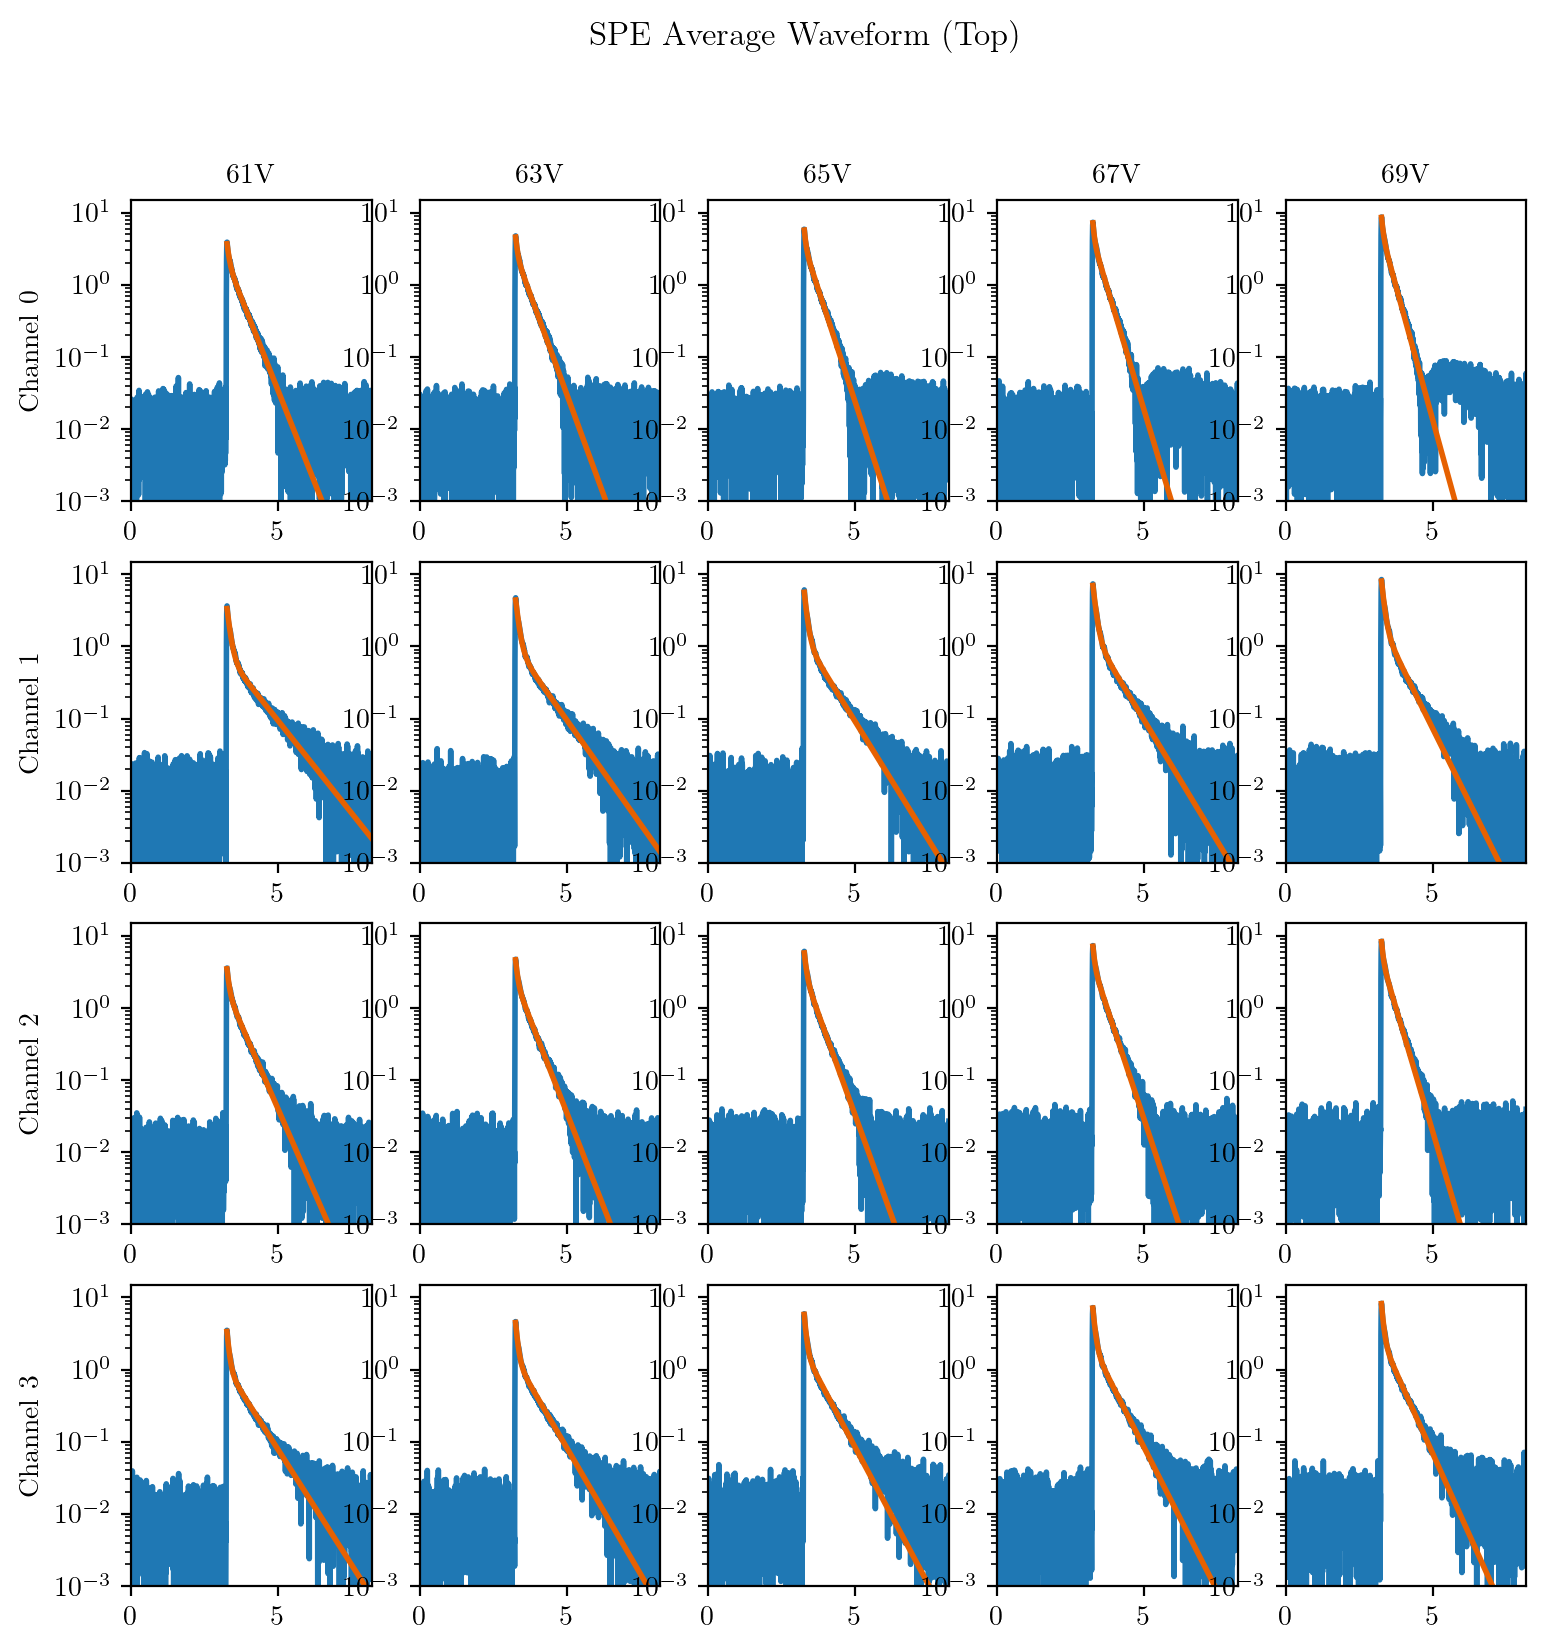

In [10]:
#for spe average waveforms
plt.figure(0,figsize=(9,9))
bias = [61, 63, 65, 67, 69]
for ch in [0,1,2,3]:
    spe_integral = []
    for i,data in enumerate(datasets):
        data.ch[ch].get_spe_avgwf()
        data.ch[ch].clear()
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(data.ch[ch].time, abs(data.ch[ch].spe_avgwf))
        err = np.std(data.ch[ch].spe_avgwf[:data.ch[ch].baseline_samples])
        popt,pcov = curve_fit(data.ch[ch].get_pulse_shape, data.ch[ch].time[data.ch[ch].trigger_position:], data.ch[ch].spe_avgwf[data.ch[ch].trigger_position:], p0=[3,0.08,3,0.5], sigma=[err]*len(data.ch[ch].time[data.ch[ch].trigger_position:]), maxfev=10000)
        plt.plot(data.ch[ch].time[data.ch[ch].trigger_position:], data.ch[ch].get_pulse_shape(data.ch[ch].time[data.ch[ch].trigger_position:],*popt))
        spe_integral.append(popt[0]*popt[1]*250+popt[2]*popt[3]*250)
        print('CH{} {}V  A1={:.3f}+/-{:.3f} TAU1={:.4f}+/-{:.4f}us A2={:.3f}+/-{:.3f} TAU2={:.4f}+/-{:.4f}us'.format(ch,bias[i],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3])))
        data.ch[ch].set_pulse_pars(a1=[popt[0],np.sqrt(pcov[0,0])], tau1=[popt[1],np.sqrt(pcov[1,1])], a2=[popt[2],np.sqrt(pcov[2,2])], tau2=[popt[3],np.sqrt(pcov[3,3])])
        plt.xlim(data.ch[ch].time[0],data.ch[ch].time[-1])
        plt.ylim(1e-3, 15)
        plt.yscale('log')
plt.suptitle('SPE Average Waveform (Top)')
# plt.savefig('../plots/sipm/spewf_top_0928.pdf')

# Bottome tile calibration (0928 data)

## Directories

In [11]:
data_dir = "/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/"
subdir = ['20220928_bottom_61V_laser_ext/',
          '20220928_bottom_63V_laser_ext/',
          '20220928_bottom_65V_laser_ext/',
          '20220928_bottom_67V_laser_ext/',
          '20220928_bottom_69V_laser_ext/']

## Process raw data and get:
* charge histograms
* filtered amplitude histograms
* average waveform

In [12]:
datasets = []
for subdir_ in subdir:
    path = "{}{}".format(data_dir, subdir_)
    data = ds.Dataset(path, pol=-1, channels=range(4), samples=2048)
    print(path)
    for i in range(4):
        data.ch[i].read_data(header=False)
        data.ch[i].baseline_subtraction()
        data.ch[i].get_integral(short=1.6, long=5)
        data.ch[i].get_integral_hist(short=[-5e2,5e3,1000], long=[-5e2,5e3,1000])
        data.ch[i].ar_filter(tau=20)
        data.ch[i].get_famp()
        data.ch[i].get_famp_hist(bin=[-1e2,1e3,1000])
        data.ch[i].clear()
    datasets.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_bottom_61V_laser_ext/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_bottom_63V_laser_ext/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_bottom_65V_laser_ext/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_bottom_67V_laser_ext/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_bottom_69V_laser_ext/


## Plot charge histogram and analyze

Channel 0 Vbd=55.381+/-0.492V slope=39.166+/-1.957
Channel 1 Vbd=55.596+/-0.089V slope=41.016+/-0.494
Channel 2 Vbd=55.976+/-0.251V slope=38.731+/-1.190
Channel 3 Vbd=54.767+/-0.141V slope=42.537+/-0.736


/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 0.98, 'Breakdown Voltage (Bottom)')

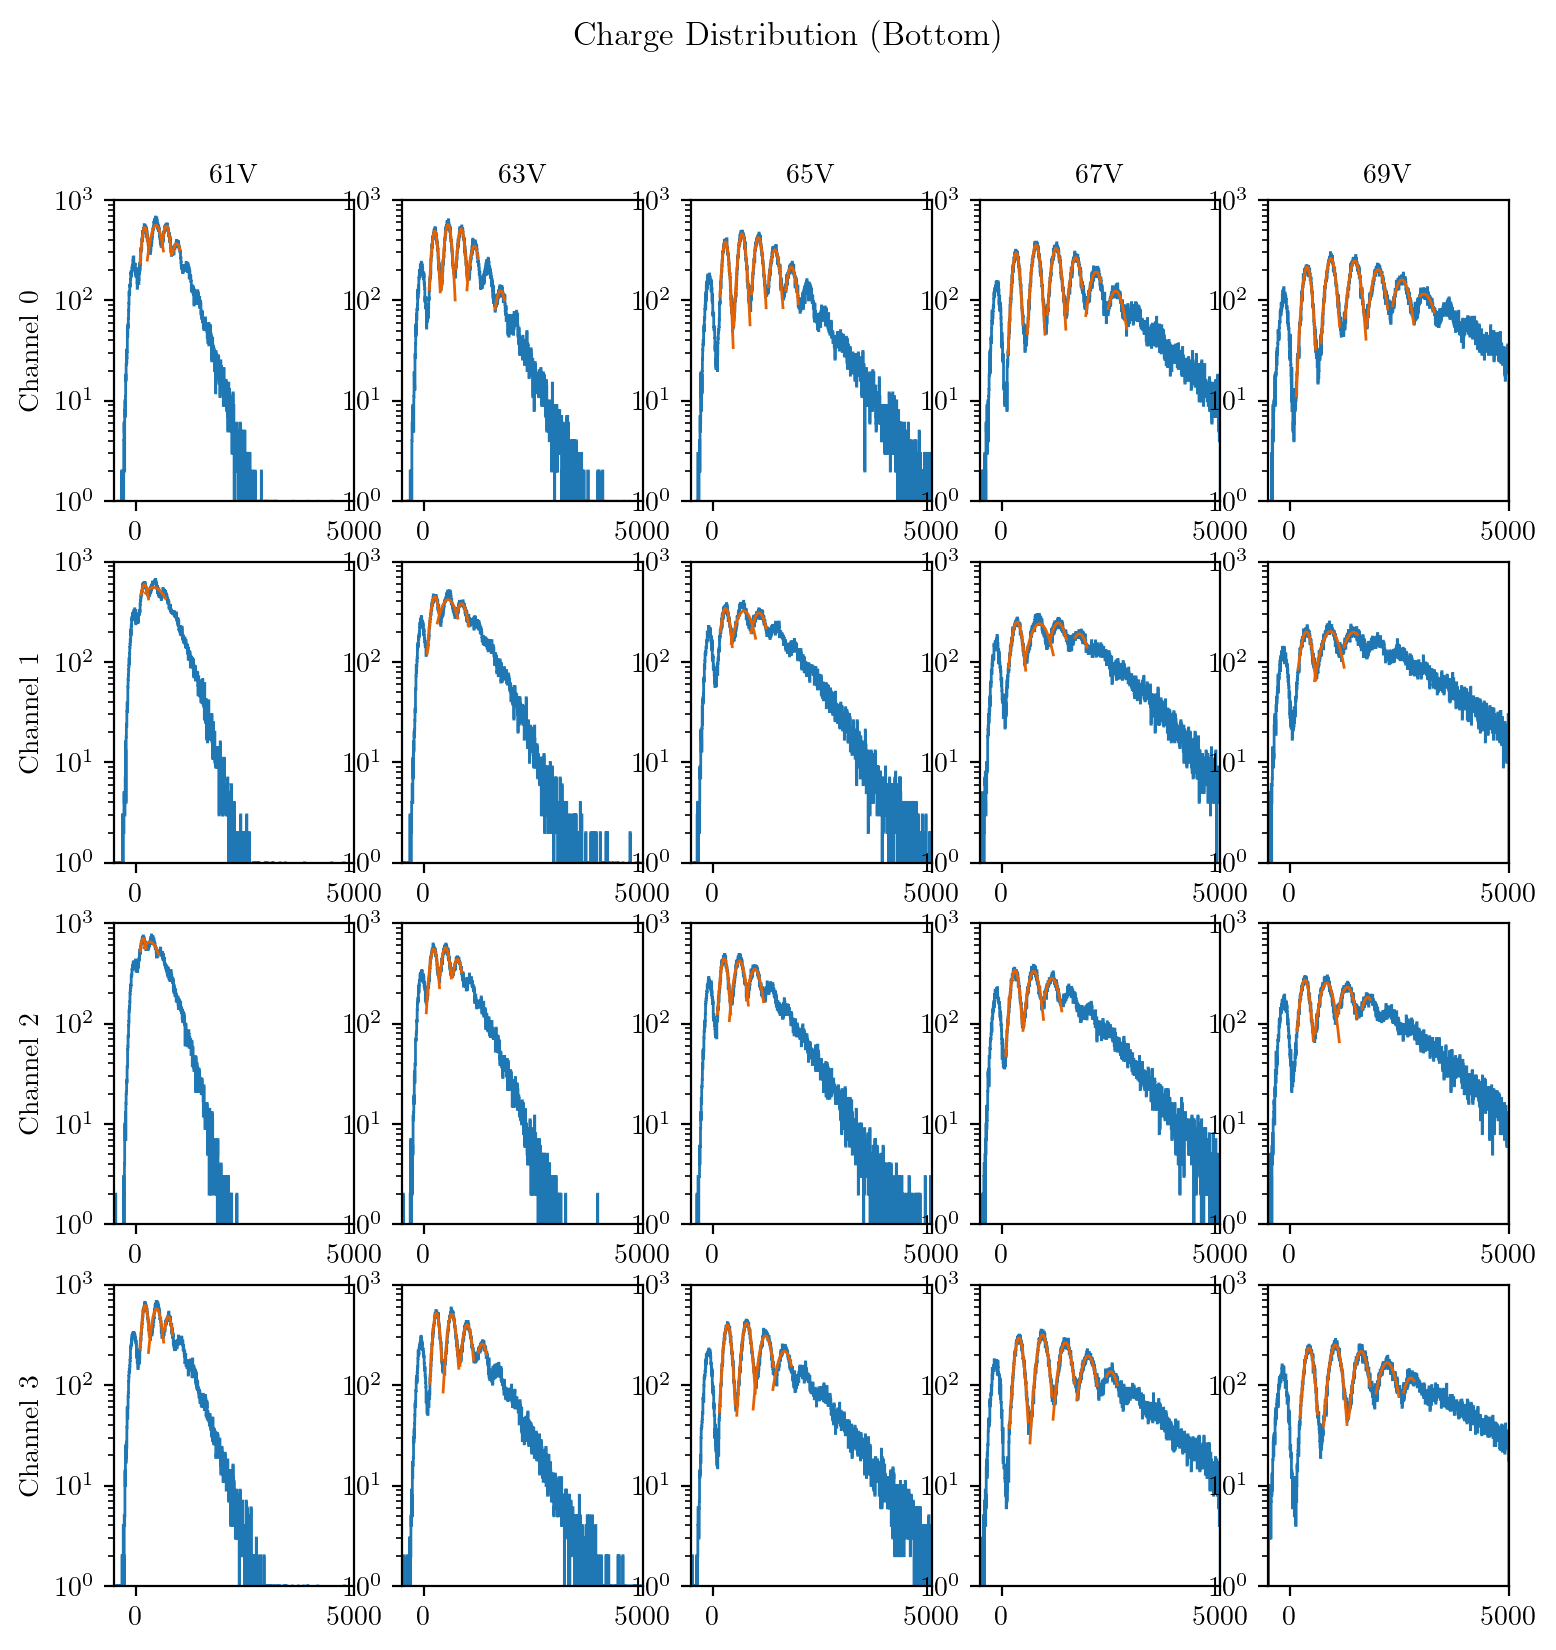

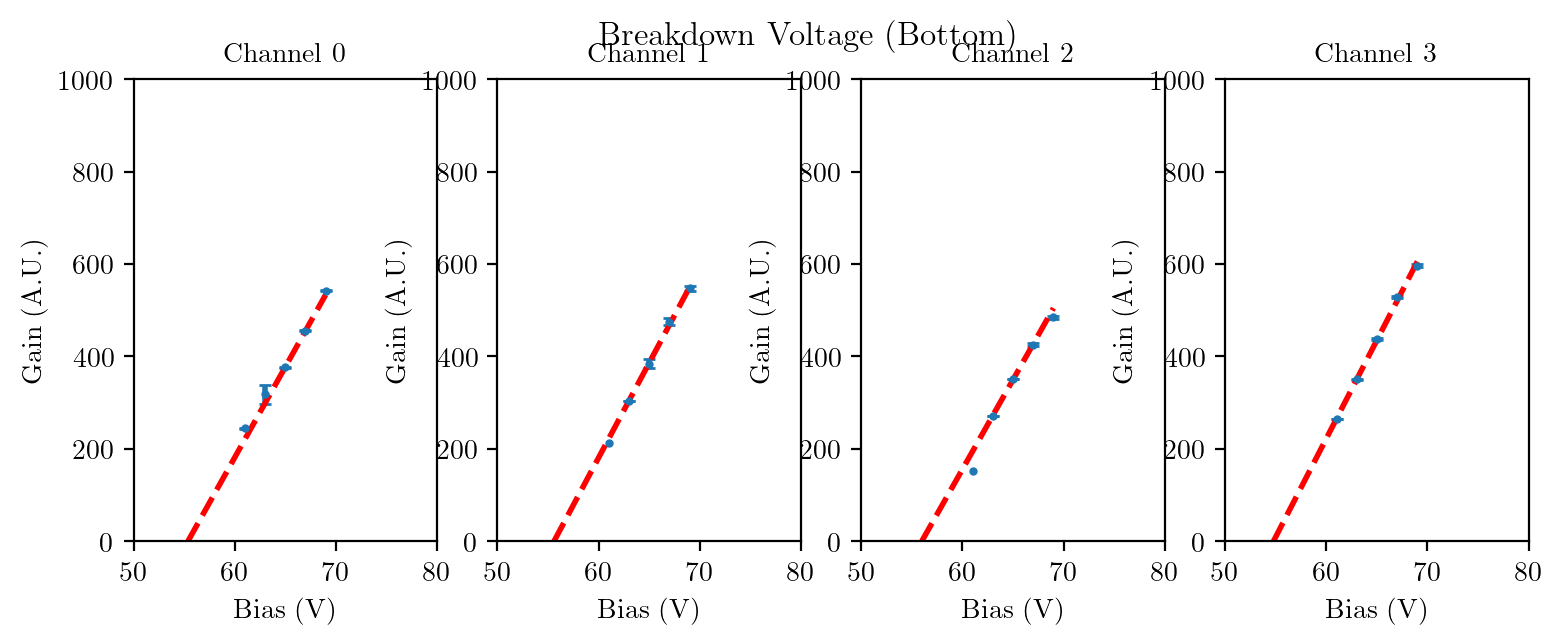

In [21]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
bias = [61, 63, 65, 67, 69]
Vbd_charge_bottom = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(datasets): 
        #charge histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].integral_short_hist, data.ch[ch].integral_short_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].integral_short_hist_bin[0], data.ch[ch].integral_short_hist_bin[-1])
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        thre = 100 #threshold to remove baseline noise
        peaks,pdict = find_peaks(data.ch[ch].integral_short_hist[thre:], prominence=30, width=13, distance=20)
        #fit pe peaks with Gaussian
        pe_mean = []
        bin_width = data.ch[ch].integral_short_hist_bin[1]-data.ch[ch].integral_short_hist_bin[0]
        peak_range = []
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + thre
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = bin_width*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = data.ch[ch].integral_short_hist_bin[0] + bin_width*min_bin
            max_x = data.ch[ch].integral_short_hist_bin[0] + bin_width*max_bin
            peak_x = data.ch[ch].integral_short_hist_bin[0] + bin_width*peak_bin
            popt,pcov = curve_fit(gauss, data.ch[ch].integral_short_hist_bin[min_bin:max_bin], data.ch[ch].integral_short_hist[min_bin:max_bin], p0=[data.ch[ch].integral_short_hist[peak_bin], peak_x, pe_width_x], sigma=np.sqrt(data.ch[ch].integral_short_hist[min_bin:max_bin]), maxfev=10000)
            plt.plot(data.ch[ch].integral_short_hist_bin[min_bin:max_bin], gauss(data.ch[ch].integral_short_hist_bin[min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
            pe_mean.append([popt[1],np.sqrt(pcov[1,1])])
            peak_range.append([popt[1]-2*popt[2],popt[1]+2*popt[2]])    
        data.ch[ch].set_calibration(integral_peaks=peak_range)
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = np.array(pe_mean)[:,0]
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=np.array(pe_mean)[:,1], maxfev=10000)
        data.ch[ch].set_calibration(gain_integral=[popt[0], np.sqrt(pcov[0,0])])
    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].gain_integral[0] for data in datasets]
    err = [data.ch[ch].gain_integral[1] for data in datasets]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], sigma=err, maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_charge_bottom[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o',markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,1000)
        
plt.figure(0)
plt.suptitle('Charge Distribution (Bottom)')
# plt.savefig('../plots/sipm/charge_histo_top_0928.pdf')
plt.figure(1)
plt.suptitle('Breakdown Voltage (Bottom)')
# plt.savefig('../plots/sipm/gain_bias_charge_top_0928.pdf')

## Plot filtered amplitude histogram and analyze

It seems like Ch1 has double peaks...

n=109471 mu=2.507 p=0.072+/-0.005
n=109114 mu=2.631 p=0.117+/-0.002
n=107830 mu=2.803 p=0.163+/-0.003
n=106758 mu=2.929 p=0.217+/-0.003
n=105442 mu=3.018 p=0.278+/-0.005
Channel 0 Vbd=55.299+/-0.078V slope=8.287+/-0.063
n=109763 mu=2.111 p=0.075+/-0.005
n=108840 mu=2.246 p=0.110+/-0.005
n=108405 mu=2.399 p=0.155+/-0.006
n=108056 mu=2.491 p=0.211+/-0.004
n=107579 mu=2.544 p=0.281+/-0.004
Channel 2 Vbd=55.110+/-0.120V slope=7.779+/-0.083
n=110184 mu=2.248 p=0.083+/-0.004
n=110073 mu=2.354 p=0.129+/-0.005
n=109171 mu=2.529 p=0.164+/-0.003
n=109456 mu=2.589 p=0.250+/-0.015
n=110526 mu=2.753 p=0.301+/-0.008
Channel 3 Vbd=55.150+/-0.082V slope=8.690+/-0.077


(0.0, 0.4)

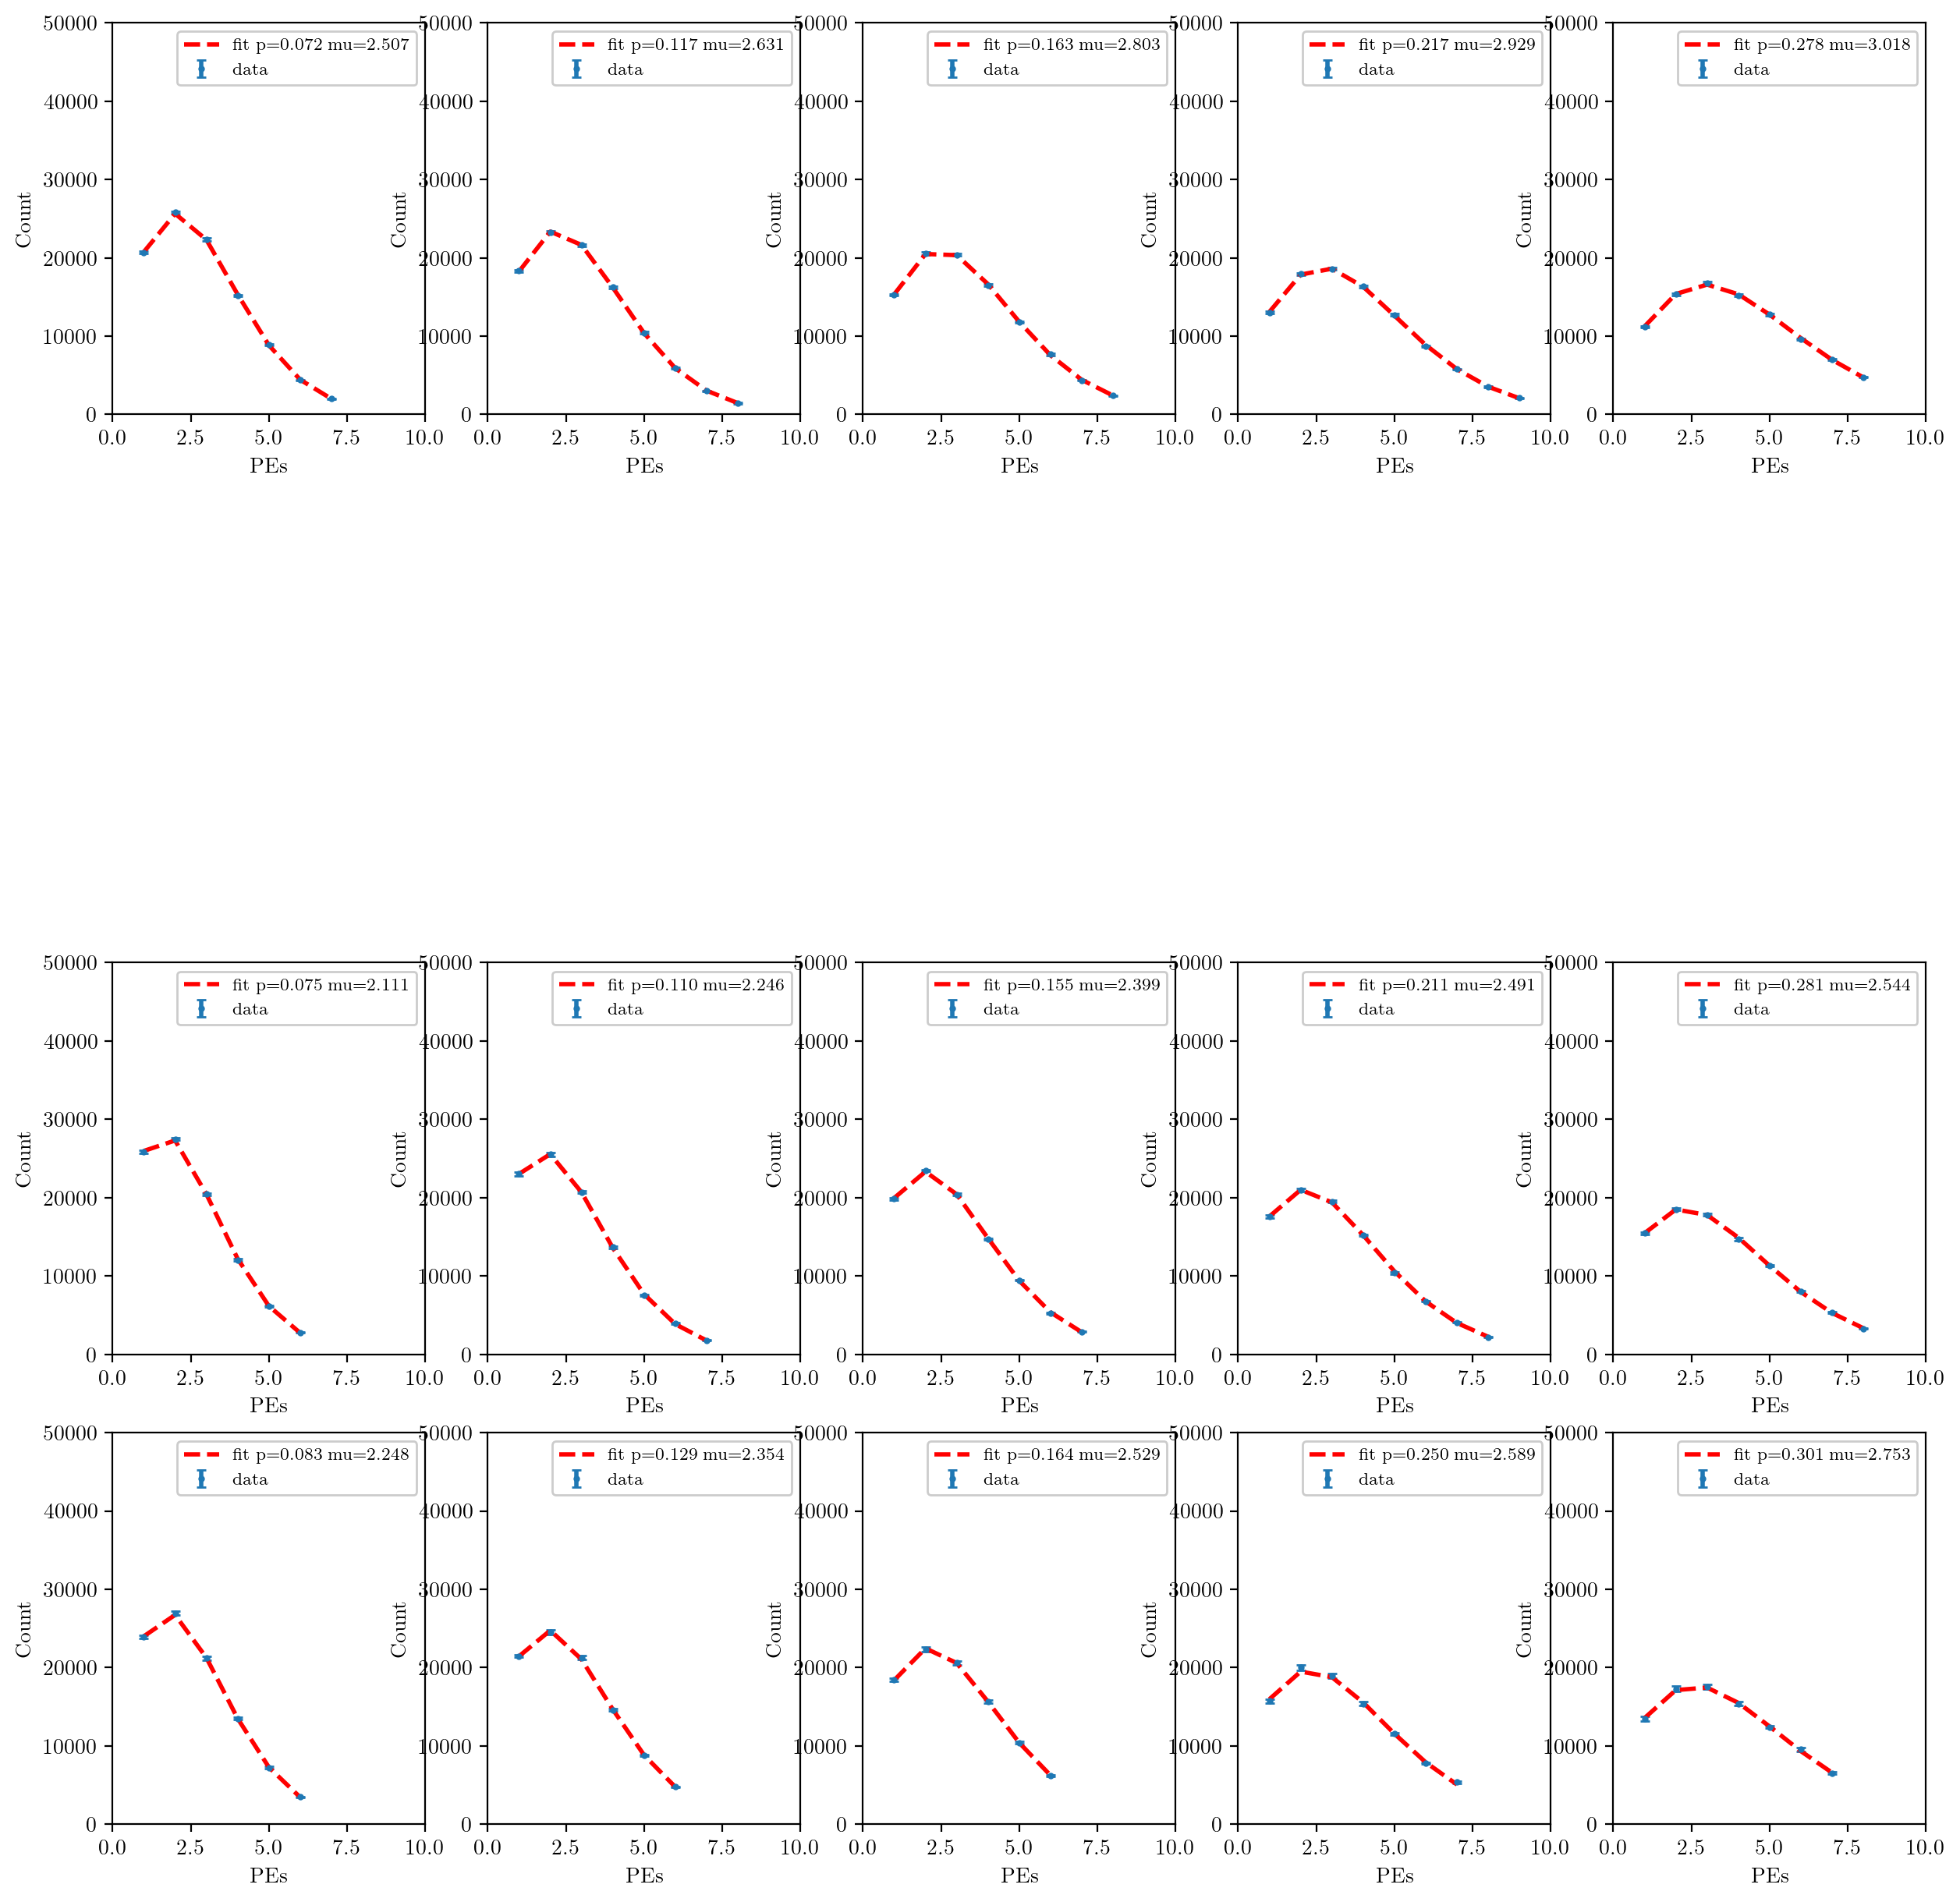

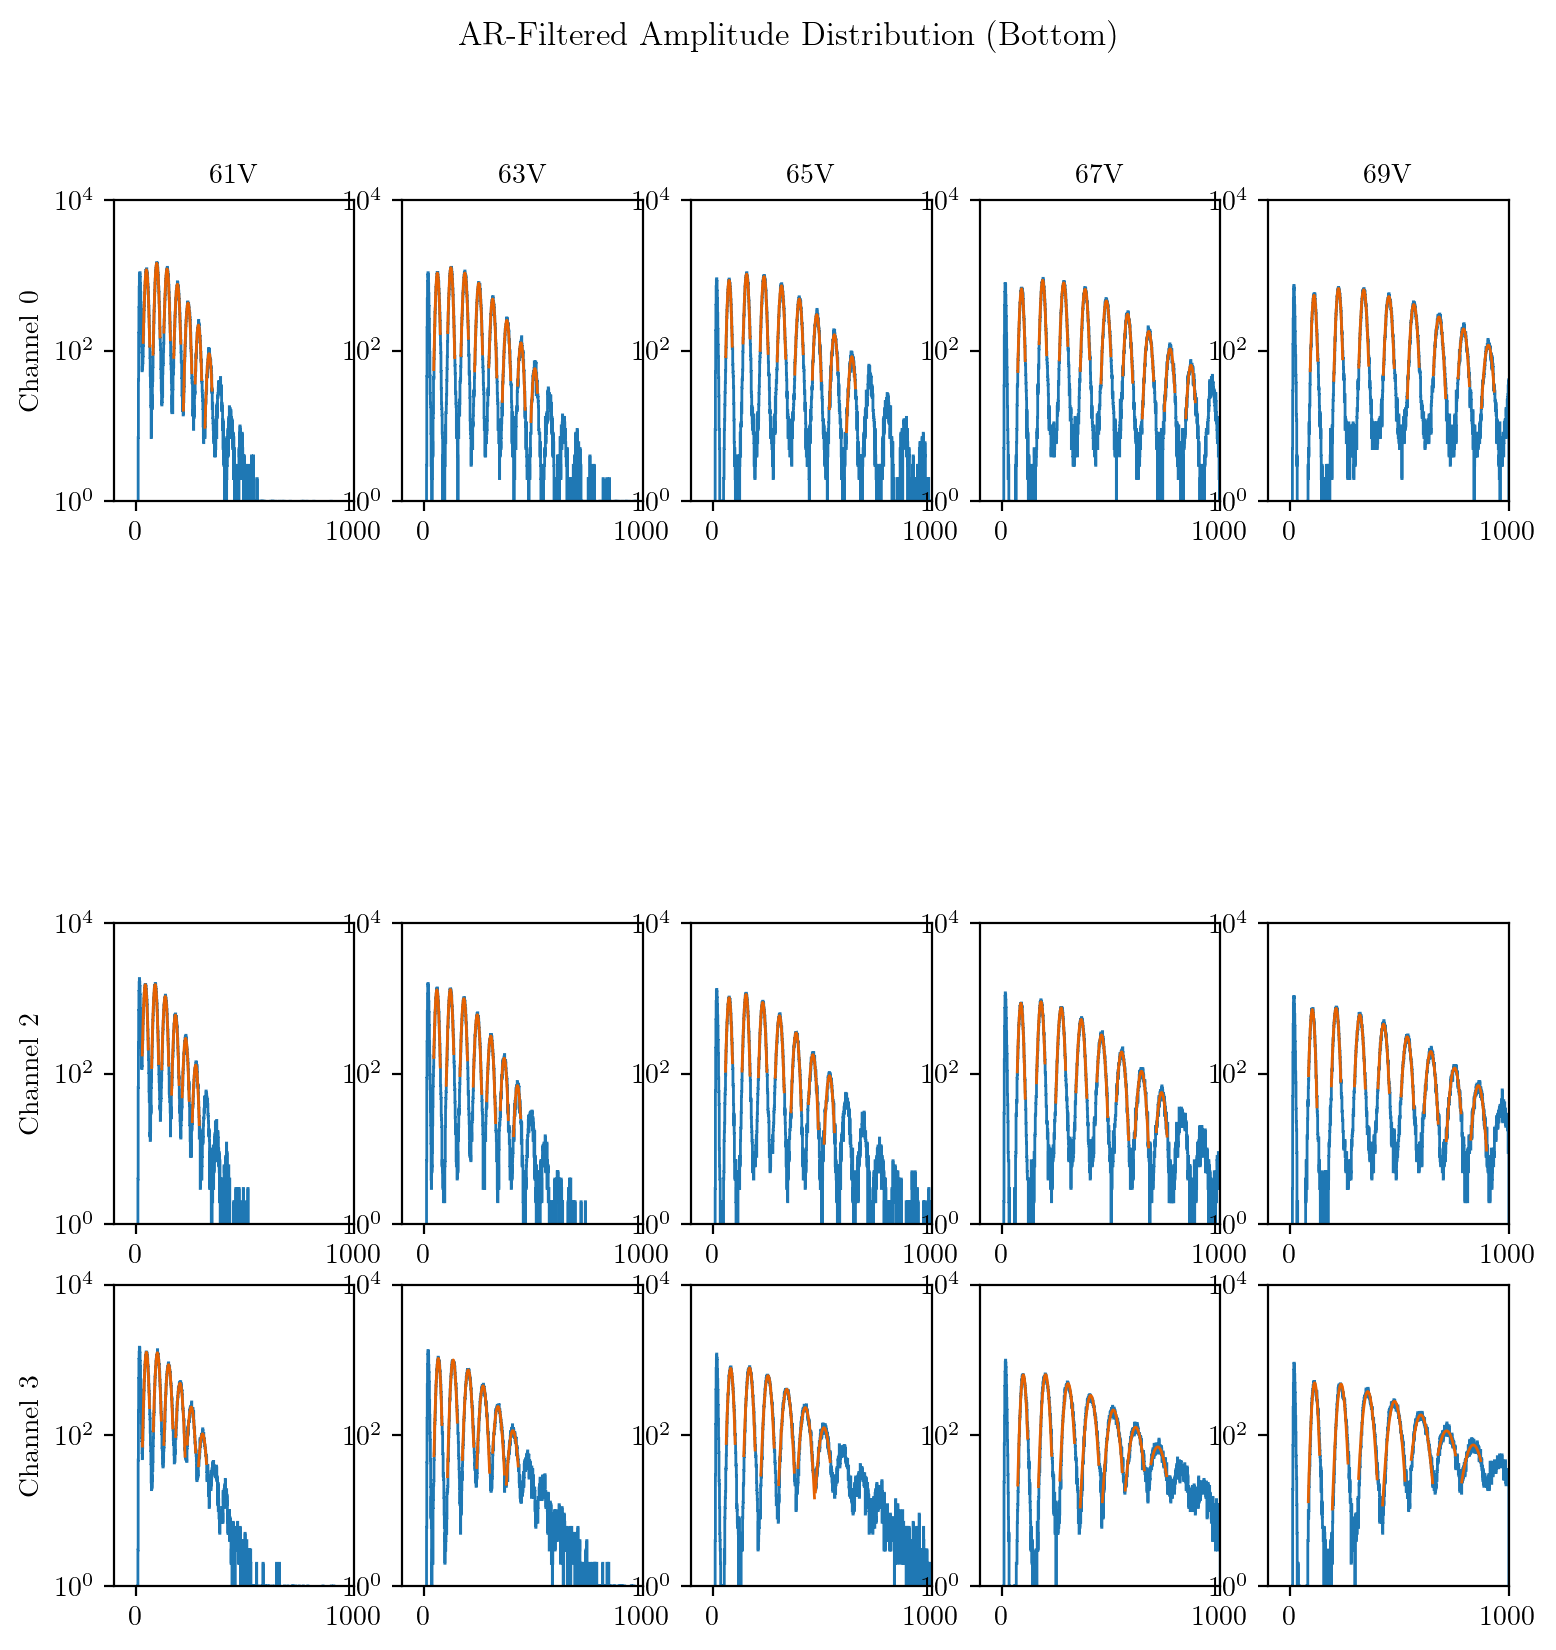

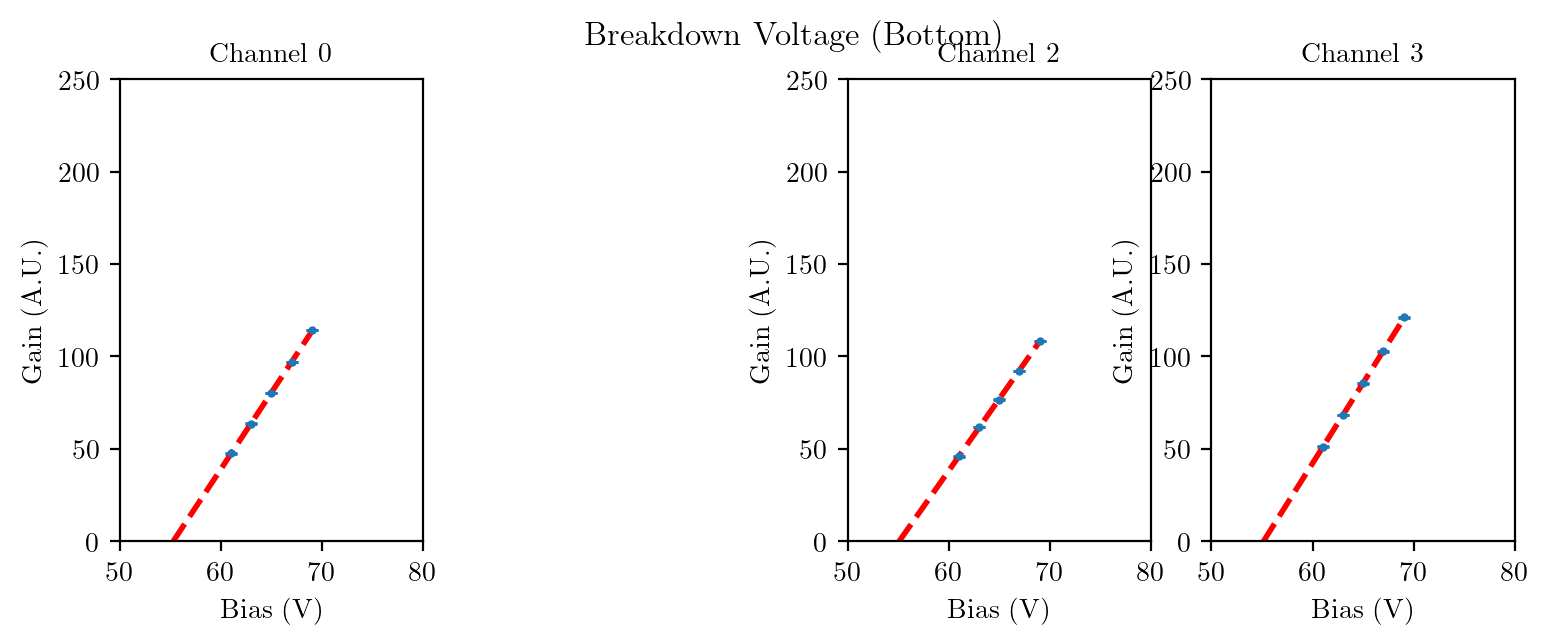

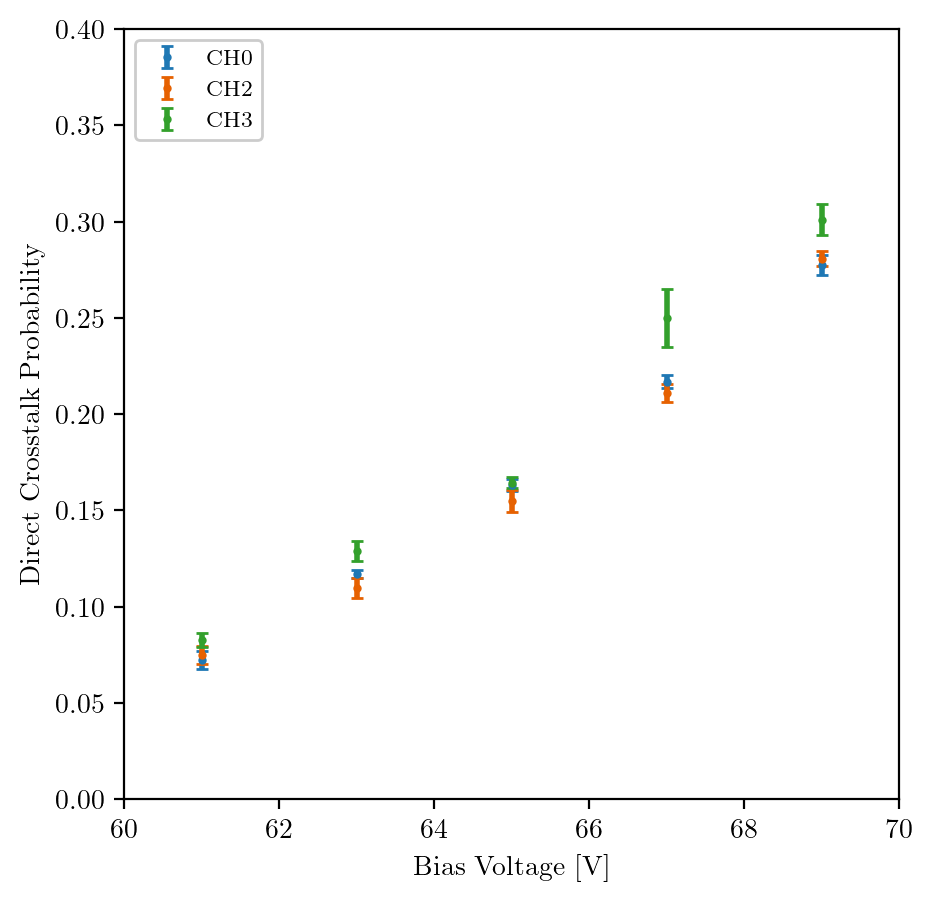

In [27]:
plt.figure(0,figsize=(9,9))#for filtered amplitude histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
plt.figure(2,figsize=(15,15))#for Vinogradov fit
plt.figure(3,figsize=(5,5)) # for crosstalk summary
bias = [61, 63, 65, 67, 69]
Vbd_famp_bottom = np.zeros((4,2))
for ch in [0,2,3]:
    for i,data in enumerate(datasets):  
        #filtered amplitude histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].famp_hist_bin[0], data.ch[ch].famp_hist_bin[-1])
        plt.ylim(1, 1e4)
        # find pe peaks in histogram
        thre = 30
        peaks,pdict = find_peaks(data.ch[ch].famp_hist[thre:], prominence=60, width=13, distance=15)
        #fit pe peaks with Gaussian
        pe_mean = []
        pe_norm = []
        peak_range = []
        bin_width = data.ch[ch].famp_hist_bin[1]-data.ch[ch].famp_hist_bin[0]
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + thre
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = bin_width*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = data.ch[ch].famp_hist_bin[0] + bin_width*min_bin
            max_x = data.ch[ch].famp_hist_bin[0] + bin_width*max_bin
            peak_x = data.ch[ch].famp_hist_bin[0] + bin_width*peak_bin
            popt,pcov = curve_fit(gauss, data.ch[ch].famp_hist_bin[min_bin:max_bin], data.ch[ch].famp_hist[min_bin:max_bin], p0=[data.ch[ch].famp_hist[peak_bin], peak_x, pe_width_x], sigma=np.sqrt(data.ch[ch].famp_hist[min_bin:max_bin]), maxfev=10000)
            plt.plot(data.ch[ch].famp_hist_bin[min_bin:max_bin], gauss(data.ch[ch].famp_hist_bin[min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
            pe_mean.append([popt[1],np.sqrt(pcov[1,1])])
            pe_norm.append([popt[0],np.sqrt(pcov[0,0])])
            peak_range.append([popt[1]-2*popt[2],popt[1]+2*popt[2]])
        data.ch[ch].set_calibration(famp_peaks=peak_range)
        
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = np.array(pe_mean)[:,0]
        err = np.array(pe_mean)[:,1]
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=err, maxfev=10000)
        data.ch[ch].set_calibration(gain_famp=[popt[0],np.sqrt(pcov[0,0])])
        #Vinogradov fit
        plt.figure(2)
        plt.subplot(4,5,ch*5+i+1)
        plt.errorbar(np.arange(1,len(pe_norm)+1), np.array(pe_norm)[:,0], yerr=np.array(pe_norm)[:,1], fmt='o', markersize=2, label='data')
        popt,pcov = curve_fit(compound_poisson, list(np.arange(1,len(pe_norm)+1)), np.array(pe_norm)[:,0], p0=[1e5, 2, 0.3], sigma=np.array(pe_norm)[:,1], maxfev=10000)
        print('n={:.0f} mu={:.3f} p={:.3f}+/-{:.3f}'.format(*popt, np.sqrt(pcov[2,2])))
        data.ch[ch].set_correlated_noise(ct=[popt[2],np.sqrt(pcov[2,2])])
        plt.plot(np.arange(1,len(pe_norm)+1), compound_poisson(np.arange(1,len(pe_norm)+1),*popt), 'r--', label='fit p={:.3f} mu={:.3f}'.format(popt[2],popt[1]))
        plt.ylim(0,5e4)
        plt.xlim(0,10)
        plt.xlabel('PEs')
        plt.ylabel('Count')
        plt.legend(loc='upper right')
    # plot crosstalk
    plt.figure(3)
    plt.errorbar(bias, [data.ch[ch].ct[0] for data in datasets], yerr=[data.ch[ch].ct[1] for data in datasets], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].gain_famp[0] for data in datasets]
    err = [data.ch[ch].gain_famp[1] for data in datasets]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_famp_bottom[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,250)
        

plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution (Bottom)')
# plt.savefig('../plots/sipm/famp_histo_top_0928.pdf')
plt.figure(1)
plt.suptitle('Breakdown Voltage (Bottom)')
# plt.savefig('../plots/sipm/gain_bias_famp_top_0928.pdf')
plt.figure(3)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Direct Crosstalk Probability')
plt.xlim(60,70)
plt.ylim(0, 0.4) 

# Breakdown voltage summary

In [23]:
plt.figure(0,figsize=(4,4))
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_charge_bottom[:,0], yerr=Vbd_charge_bottom[:,1], label='Charge', ls='none')
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_famp_bottom[:,0], yerr=Vbd_famp_bottom[:,1], label='Filtered Amplitude', ls='none')
plt.xlim(-1,4)
plt.ylim(53,57)
plt.xlabel('Channel')
plt.ylabel('Breakdown Voltage (V)')
plt.title('Bottom Tile')
plt.legend()
plt.show()
# plt.savefig('../plots/sipm/vbd_bottom_0928.pdf')

## Examine after-pulses
Time window = $5~\rm\mu s$.
$\mu$ of Gaussian fit is regarded as the spe gain, while the overall average is $\mu(1+ap)$ where $ap$ is the afterpulse charge per pe.
The right tails are due to afterpulses.


SPE(1+AP) = 333.8867462567525+/-1.799983374858303
SPE(1+AP) = 409.5308976523207+/-0.7307839234652213
SPE(1+AP) = 508.7948034968484+/-0.6499869396092292
SPE(1+AP) = 615.5544599538334+/-1.281266243970003
SPE(1+AP) = 730.7798270338559+/-1.1753293094532404
SPE(1+AP) = 297.08960642547413+/-0.9791017671363765
SPE(1+AP) = 390.38526873608623+/-1.0219078724537065
SPE(1+AP) = 490.8765143028627+/-0.3445997737597081
SPE(1+AP) = 593.2851822642253+/-2.128711488740822
SPE(1+AP) = 680.4752898232962+/-1.0318276753438933
SPE(1+AP) = 320.00234055117335+/-0.8486526156920853
SPE(1+AP) = 420.67664874059153+/-1.2235317947002138
SPE(1+AP) = 525.7944336937883+/-0.5887716364430716
SPE(1+AP) = 637.7753986757331+/-1.1962256664091286
SPE(1+AP) = 726.3972970634715+/-0.9376095670573692


(-0.01, 0.06)

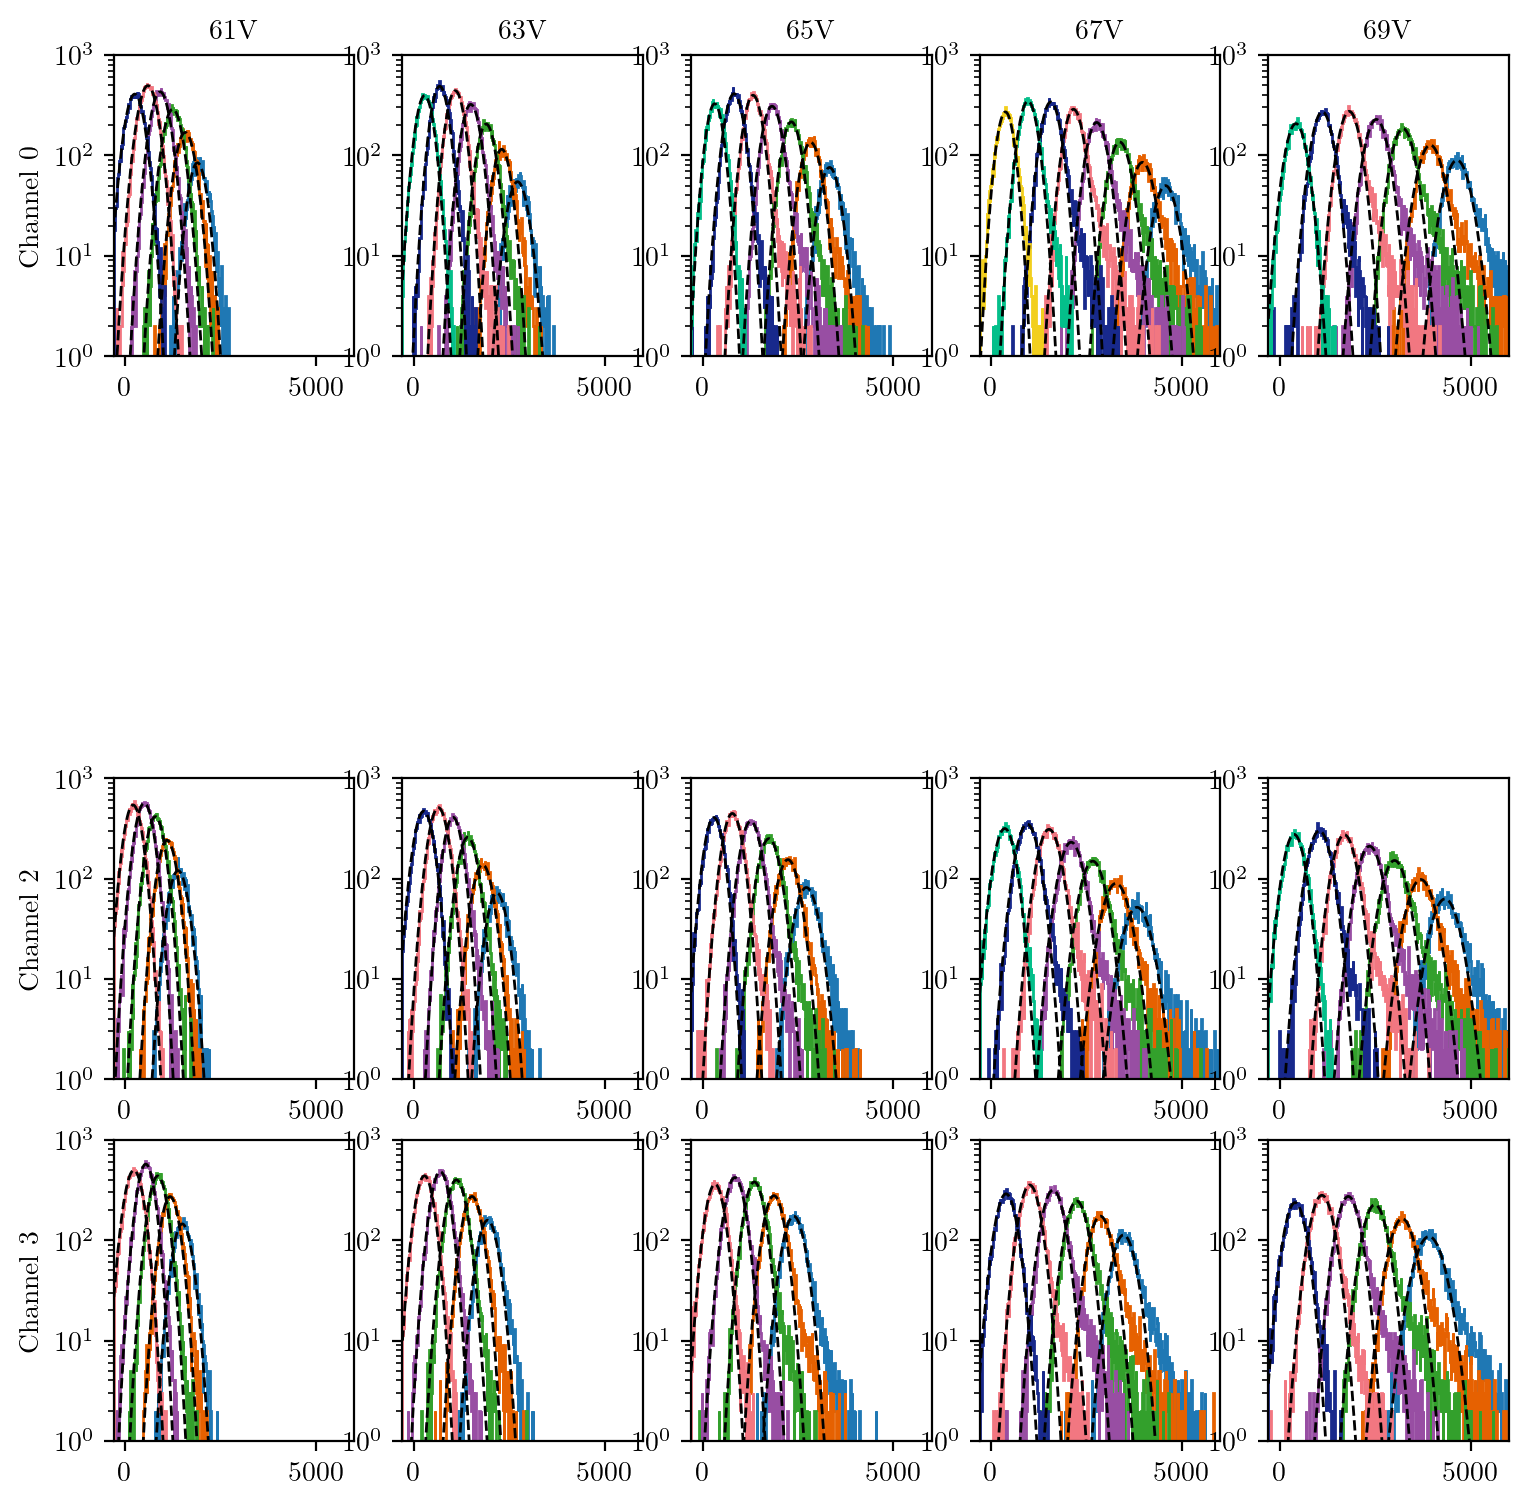

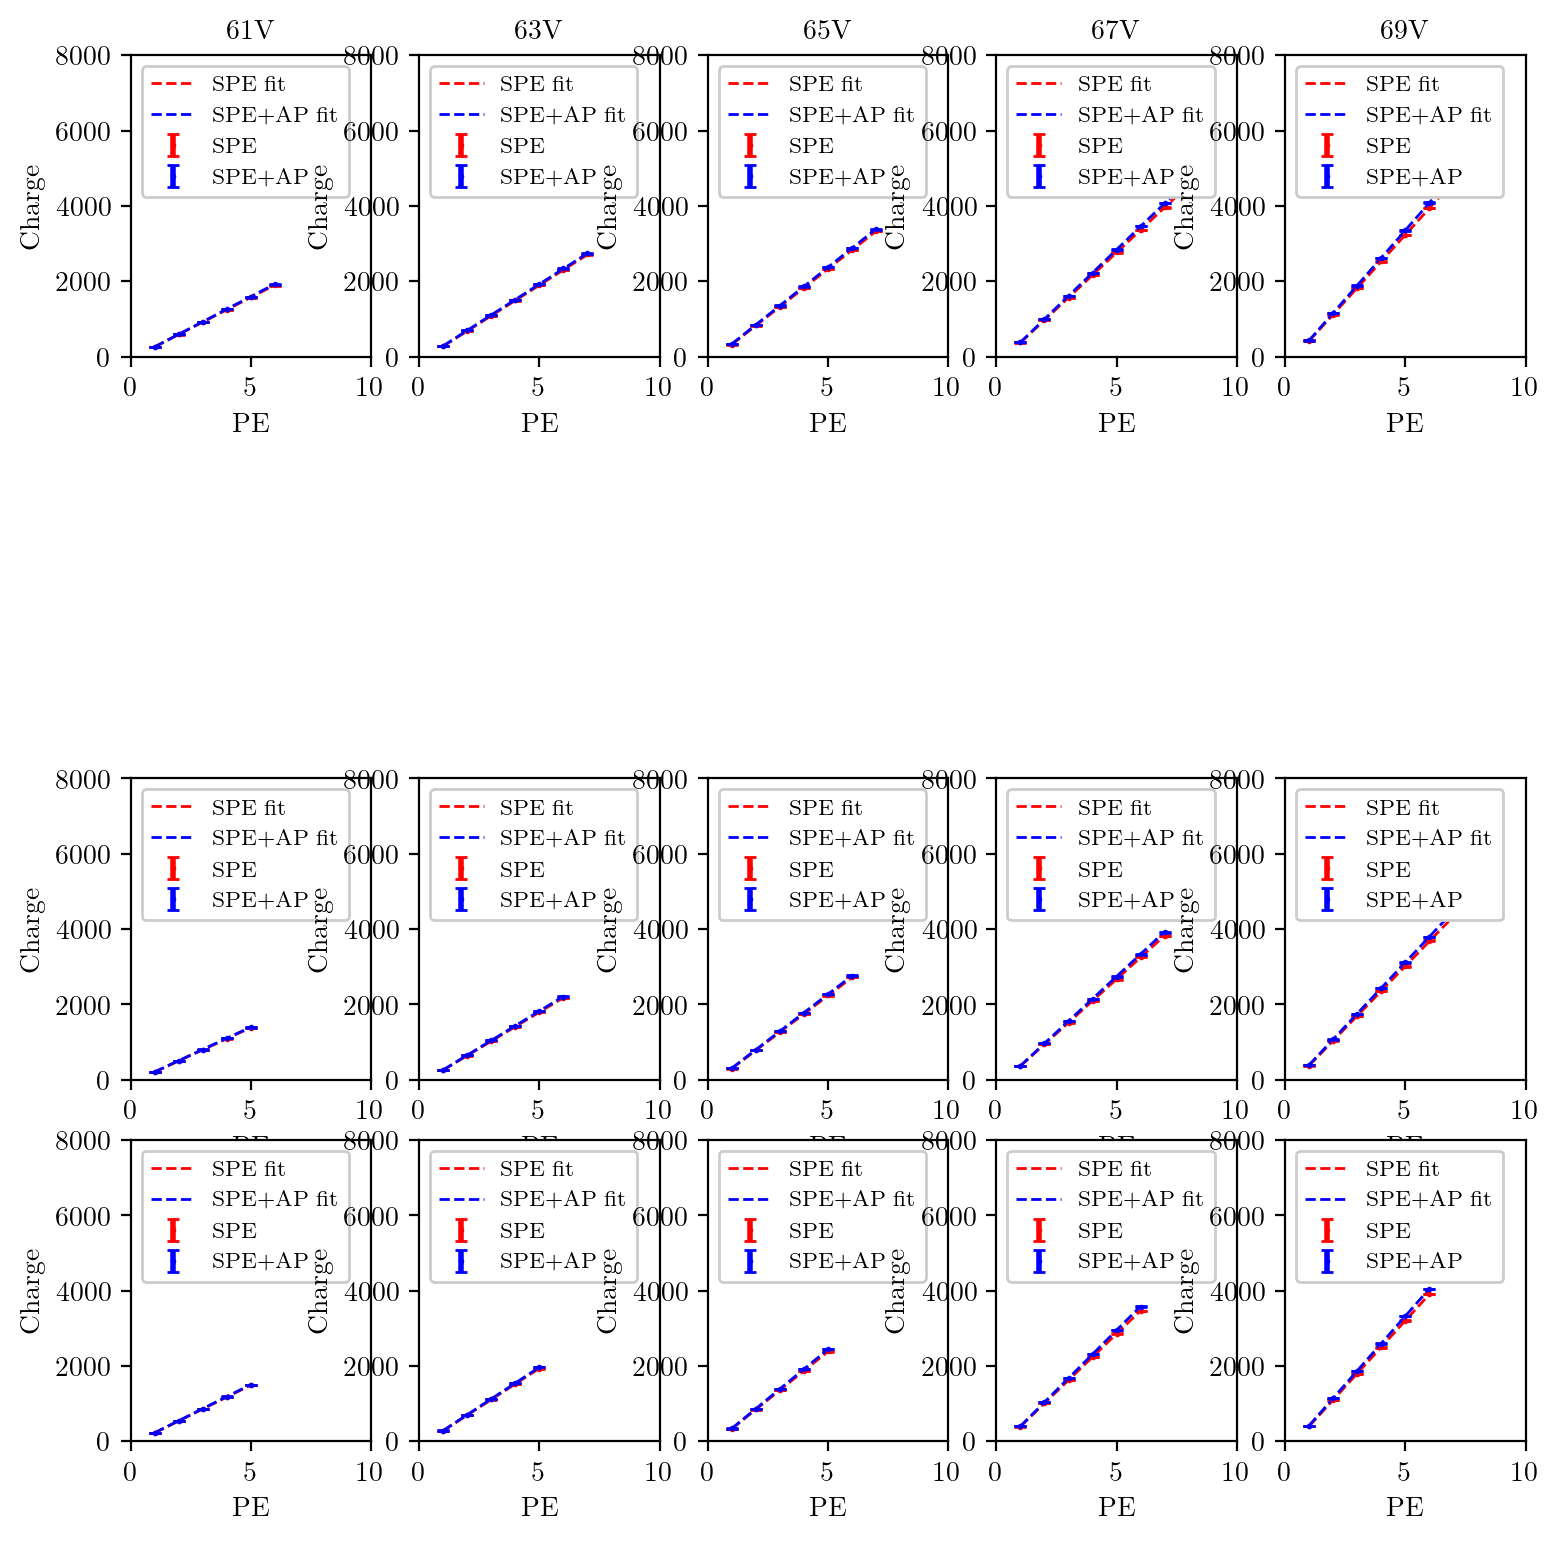

In [26]:
plt.figure(0,figsize=(9,9))
plt.figure(1,figsize=(9,9))
plt.figure(2,figsize=(4,4))

x_min=-300
x_max=6000
n_bins=500

for ch in [0,2,3]:
    for i,data in enumerate(datasets):
        mu_pe = []
        avg_pe = []
        data.ch[ch].get_afterpulse_charge(xmin=x_min,xmax=x_max,nbins=n_bins)
        bin_width = (x_max-x_min)/n_bins
        #histogram and Gaussian fit
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        for j in np.arange(len(data.ch[ch].ap_charge)-2,-1,-1):
            plt.stairs(data.ch[ch].ap_charge_hist[j], data.ch[ch].ap_charge_hist_bin[j])
            avg_pe.append([np.mean(data.ch[ch].ap_charge[j]), np.std(data.ch[ch].ap_charge[j])/np.sqrt(len(data.ch[ch].ap_charge[j]))])
            w = int(np.std(data.ch[ch].ap_charge[j])/bin_width) # in bin
            p = np.argmax(data.ch[ch].ap_charge_hist[j]) # in bin
            popt,pcov = curve_fit(gauss, data.ch[ch].ap_charge_hist_bin[j][p-w:p+w], data.ch[ch].ap_charge_hist[j][p-w:p+w], p0=[np.max(data.ch[ch].ap_charge_hist[j])*w*bin_width,p*bin_width,w*bin_width], sigma=np.sqrt(data.ch[ch].ap_charge_hist[j][p-w:p+w]), maxfev=100000)
            plt.plot(data.ch[ch].ap_charge_hist_bin[j][:-1], gauss(data.ch[ch].ap_charge_hist_bin[j][:-1], *popt), 'k--', linewidth=1)
            mu_pe.append([popt[1],np.sqrt(pcov[1,1])])
        plt.xlim(data.ch[ch].ap_charge_hist_bin[0][0], data.ch[ch].ap_charge_hist_bin[0][-1])
        plt.ylim(1,1e3)
        plt.yscale('log')
        # plot mu-pe vs avg-pe
        mu_pe = list(reversed(mu_pe))
        avg_pe = list(reversed(avg_pe))
        plt.figure(1)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(mu_pe)[:,0], yerr=np.array(mu_pe)[:,1], fmt='r.', markersize=2, label='SPE')
        popt,pcov=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(mu_pe)[:,0], p0=[500,0], sigma=np.array(mu_pe)[:,1], maxfev=10000)
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1)+1, line(np.arange(len(data.ch[ch].ap_charge)-1)+1, *popt), 'r--', label='SPE fit', linewidth=1)
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(avg_pe)[:,0], yerr=np.array(avg_pe)[:,1], fmt='b.', markersize=2, label='SPE+AP')
        popt_,pcov_=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1)+1,np.array(avg_pe)[:,0], p0=[500,0], sigma=np.array(avg_pe)[:,1], maxfev=10000)
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1)+1, line(np.arange(len(data.ch[ch].ap_charge)-1)+1, *popt_), 'b--', label='SPE+AP fit', linewidth=1)
        plt.xlabel('PE')
        plt.ylabel('Charge')
        data.ch[ch].set_correlated_noise(ap=[popt_[0]/popt[0]-1, popt_[0]/popt[0]*np.sqrt(pcov[0,0]/popt[0]**2+pcov_[0,0]/popt_[0]**2)])
        data.ch[ch].set_calibration(gain_integral=[popt[0],np.sqrt(pcov[0,0])])
        print('SPE(1+AP) = {}+/-{}'.format(popt_[0], np.sqrt(pcov_[0,0])))
        plt.xlim(0,10)
        plt.ylim(0,8000)
        plt.legend()
    # plot after-pulses
    plt.figure(2)
    plt.errorbar(bias, [data.ch[ch].ap[0] for data in datasets], yerr=[data.ch[ch].ap[1] for data in datasets], label='CH{}'.format(ch), fmt='o', markersize=2)
plt.figure(2)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Afterpulse charge [PE/PE]')
plt.xlim(60,70)
plt.ylim(-0.01, 0.06) 


## SPE average waveform

CH0 61V  A1=2.754+/-0.013 TAU1=0.0853+/-0.0008us A2=0.736+/-0.007 TAU2=1.0190+/-0.0105us
CH0 63V  A1=3.513+/-0.016 TAU1=0.0793+/-0.0007us A2=0.883+/-0.009 TAU2=0.9496+/-0.0100us
CH0 65V  A1=4.395+/-0.020 TAU1=0.0770+/-0.0007us A2=1.116+/-0.012 TAU2=0.8725+/-0.0093us
CH0 67V  A1=5.622+/-0.026 TAU1=0.0732+/-0.0007us A2=1.364+/-0.016 TAU2=0.7984+/-0.0094us
CH0 69V  A1=6.660+/-0.027 TAU1=0.0789+/-0.0006us A2=1.571+/-0.019 TAU2=0.7401+/-0.0085us
CH1 61V  A1=3.032+/-0.012 TAU1=0.1051+/-0.0008us A2=0.478+/-0.007 TAU2=1.1467+/-0.0177us
CH1 63V  A1=3.960+/-0.015 TAU1=0.1060+/-0.0008us A2=0.591+/-0.009 TAU2=1.1533+/-0.0181us
CH1 65V  A1=5.247+/-0.022 TAU1=0.0978+/-0.0008us A2=0.761+/-0.014 TAU2=1.0189+/-0.0188us
CH1 67V  A1=6.315+/-0.023 TAU1=0.1086+/-0.0008us A2=0.956+/-0.017 TAU2=0.9639+/-0.0161us
CH1 69V  A1=6.927+/-0.032 TAU1=0.1018+/-0.0009us A2=1.222+/-0.026 TAU2=0.8050+/-0.0151us
CH2 61V  A1=2.867+/-0.012 TAU1=0.0827+/-0.0006us A2=0.453+/-0.005 TAU2=1.2923+/-0.0163us
CH2 63V  A1=3.827+/-0

Text(0.5, 0.98, 'SPE Average Waveform (Bottom)')

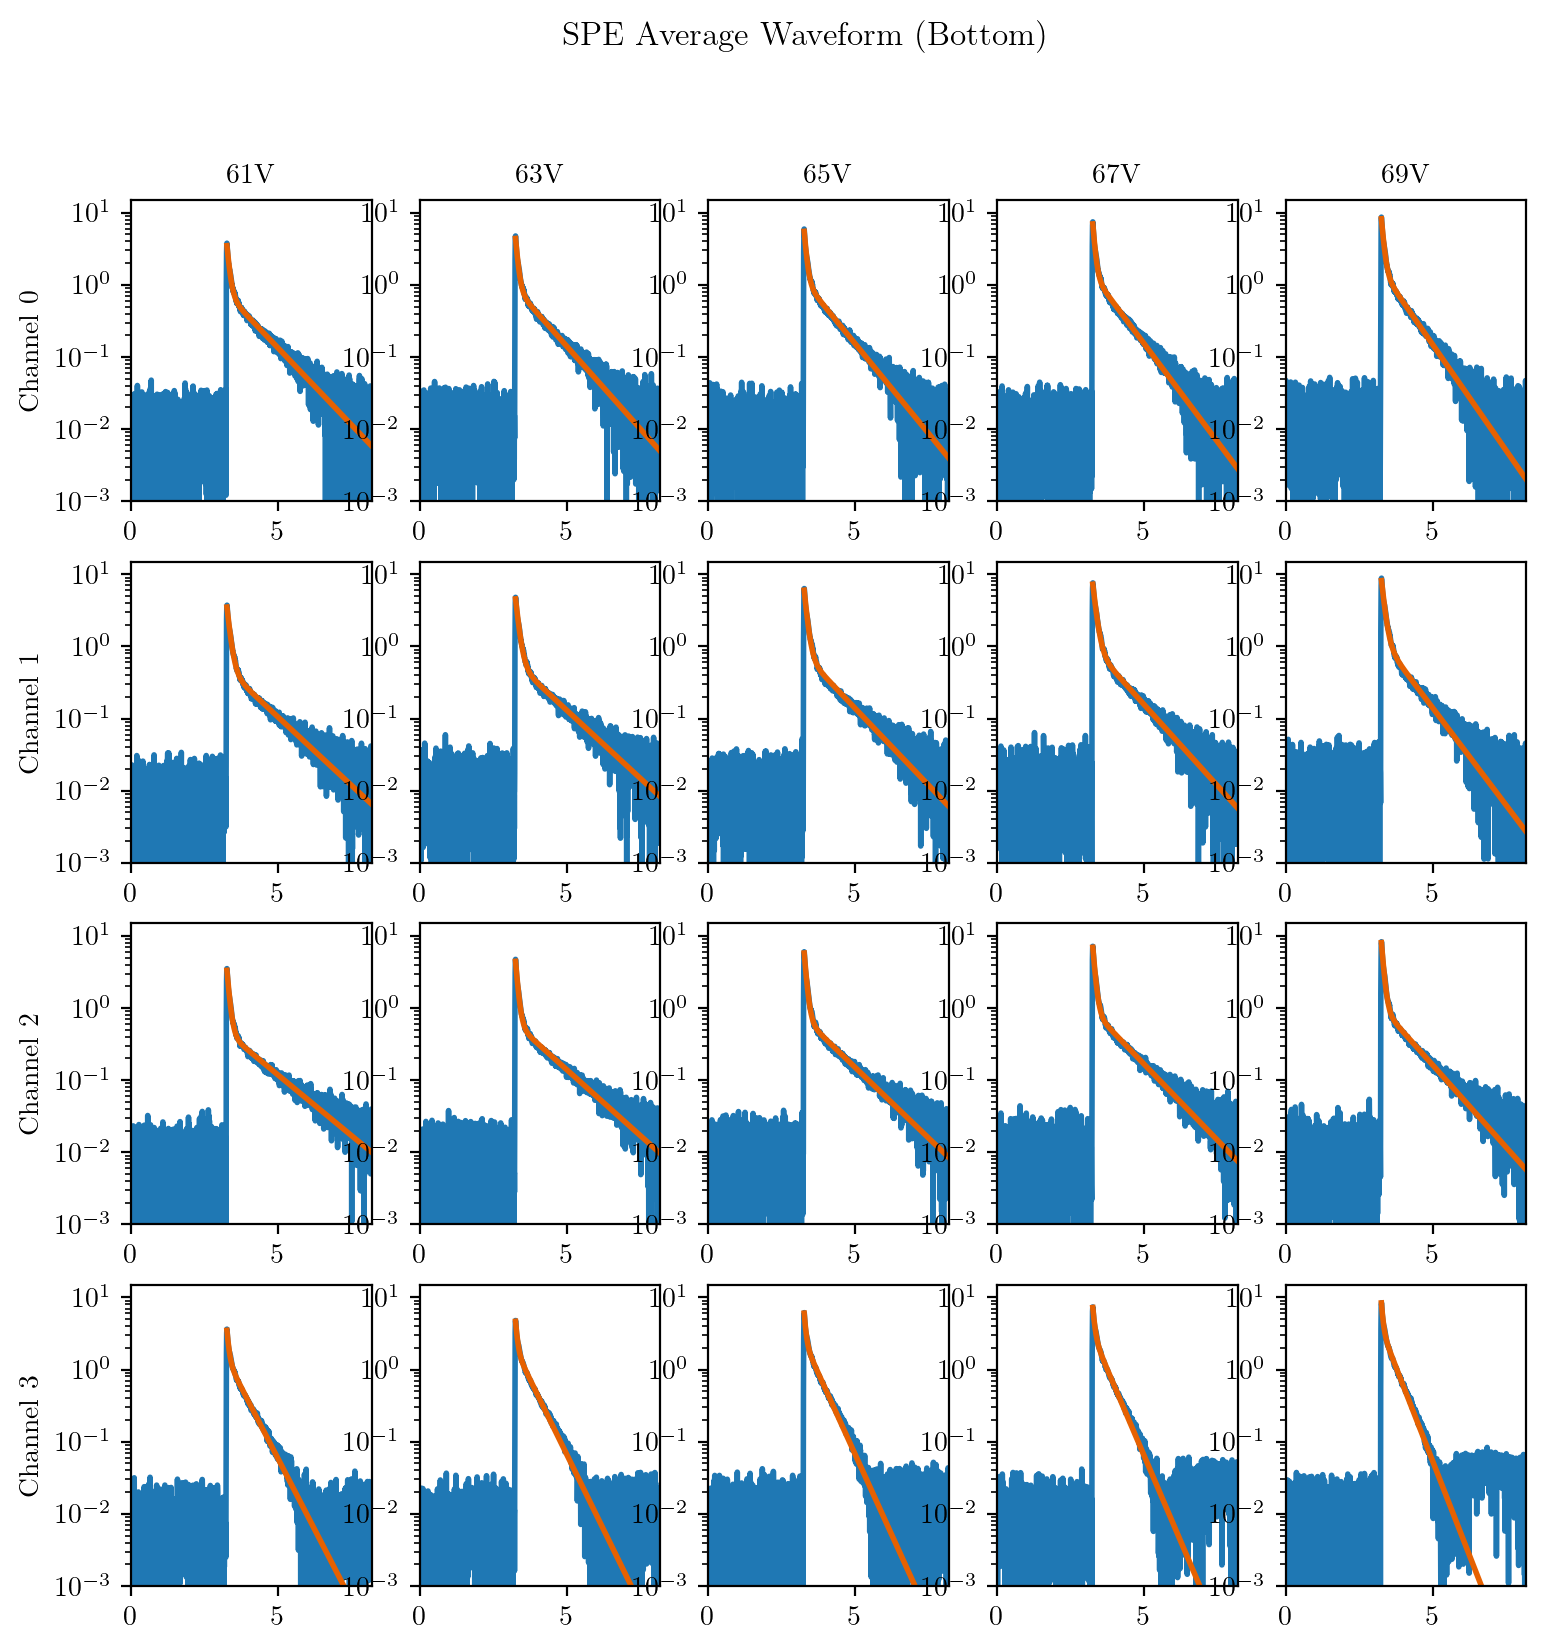

In [25]:
#for spe average waveforms
plt.figure(0,figsize=(9,9))
bias = [61, 63, 65, 67, 69]
for ch in [0,1,2,3]:
    spe_integral = []
    for i,data in enumerate(datasets):
        data.ch[ch].get_spe_avgwf()
        data.ch[ch].clear()
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(data.ch[ch].time, abs(data.ch[ch].spe_avgwf))
        err = np.std(data.ch[ch].spe_avgwf[:data.ch[ch].baseline_samples])
        popt,pcov = curve_fit(data.ch[ch].get_pulse_shape, data.ch[ch].time[data.ch[ch].trigger_position:], data.ch[ch].spe_avgwf[data.ch[ch].trigger_position:], p0=[3,0.08,3,0.5], sigma=[err]*len(data.ch[ch].time[data.ch[ch].trigger_position:]), maxfev=10000)
        plt.plot(data.ch[ch].time[data.ch[ch].trigger_position:], data.ch[ch].get_pulse_shape(data.ch[ch].time[data.ch[ch].trigger_position:],*popt))
        spe_integral.append(popt[0]*popt[1]*250+popt[2]*popt[3]*250)
        print('CH{} {}V  A1={:.3f}+/-{:.3f} TAU1={:.4f}+/-{:.4f}us A2={:.3f}+/-{:.3f} TAU2={:.4f}+/-{:.4f}us'.format(ch,bias[i],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3])))
        data.ch[ch].set_pulse_pars(a1=[popt[0],np.sqrt(pcov[0,0])], tau1=[popt[1],np.sqrt(pcov[1,1])], a2=[popt[2],np.sqrt(pcov[2,2])], tau2=[popt[3],np.sqrt(pcov[3,3])])
        plt.xlim(data.ch[ch].time[0],data.ch[ch].time[-1])
        plt.ylim(1e-3, 15)
        plt.yscale('log')
plt.suptitle('SPE Average Waveform (Bottom)')
# plt.savefig('../plots/sipm/spewf_top_0928.pdf')